In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.constraints import max_norm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
%matplotlib inline

2023-12-05 20:16:02.264857: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Goal:** This is a big dataset with with a large number of features. Upon exploring the dataset, I want to figure out the following:
- The feature that I want my classification model to predict (which would probably be loan_status)
- The features that have some correlation with the feature I want to predict

In [2]:
df = pd.read_csv('./lending-club-data/accepted_2007_to_2018Q4.csv.gz', compression='gzip', low_memory=True)

display(df)

/var/folders/16/cclqjy7n72d14ngr0ys9zwjr0000gn/T/ipykernel_14628/3076019038.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./lending-club-data/accepted_2007_to_2018Q4.csv.gz', compression='gzip', low_memory=True)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260696,88985880,NaN,40000.0,40000.0,40000.0,60 months,10.49,859.56,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260697,88224441,NaN,24000.0,24000.0,24000.0,60 months,14.49,564.56,C,C4,...,NaN,NaN,Cash,Y,Mar-2019,ACTIVE,Mar-2019,10000.0,44.82,1.0
2260698,88215728,NaN,14000.0,14000.0,14000.0,60 months,14.49,329.33,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2260699,Total amount funded in policy code 1: 1465324575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.shape

(2260701, 151)

In [4]:
# Show the name of every column in the dataset 
for index, column in enumerate(df.columns, start=1):
    print(f'{index}. {column}')

1. id
2. member_id
3. loan_amnt
4. funded_amnt
5. funded_amnt_inv
6. term
7. int_rate
8. installment
9. grade
10. sub_grade
11. emp_title
12. emp_length
13. home_ownership
14. annual_inc
15. verification_status
16. issue_d
17. loan_status
18. pymnt_plan
19. url
20. desc
21. purpose
22. title
23. zip_code
24. addr_state
25. dti
26. delinq_2yrs
27. earliest_cr_line
28. fico_range_low
29. fico_range_high
30. inq_last_6mths
31. mths_since_last_delinq
32. mths_since_last_record
33. open_acc
34. pub_rec
35. revol_bal
36. revol_util
37. total_acc
38. initial_list_status
39. out_prncp
40. out_prncp_inv
41. total_pymnt
42. total_pymnt_inv
43. total_rec_prncp
44. total_rec_int
45. total_rec_late_fee
46. recoveries
47. collection_recovery_fee
48. last_pymnt_d
49. last_pymnt_amnt
50. next_pymnt_d
51. last_credit_pull_d
52. last_fico_range_high
53. last_fico_range_low
54. collections_12_mths_ex_med
55. mths_since_last_major_derog
56. policy_code
57. application_type
58. annual_inc_joint
59. dti_joi

#### Give ChatGPT the column names and get their definitions 

| Feature No. | Feature Name                                  | Description |
|-------------|-----------------------------------------------|-------------|
| 1           | id                                            | Unique identifier for the loan |
| 2           | member_id                                     | Unique identifier for the member or borrower |
| 3           | loan_amnt                                     | The amount of loan applied for |
| 4           | funded_amnt                                   | The amount of loan funded |
| 5           | funded_amnt_inv                               | The amount of loan funded by investors |
| 6           | term                                          | The term of the loan in months |
| 7           | int_rate                                      | Interest rate on the loan |
| 8           | installment                                   | Monthly payment owed by the borrower |
| 9           | grade                                         | Loan grade based on risk level |
| 10          | sub_grade                                     | Sub-grade within the overall loan grade |
| 11          | emp_title                                     | Job title of the borrower |
| 12          | emp_length                                    | Employment length in years |
| 13          | home_ownership                                | Borrower's home ownership status (e.g., rent, own) |
| 14          | annual_inc                                    | Borrower's annual income |
| 15          | verification_status                           | Indicates if income was verified |
| 16          | issue_d                                       | The month the loan was funded |
| 17          | loan_status                                   | Current status of the loan |
| 18          | pymnt_plan                                    | Indicates if a payment plan has been put in place |
| 19          | url                                           | URL for the specific loan |
| 20          | desc                                          | Loan description provided by the borrower |
| 21          | purpose                                       | Purpose of the loan |
| 22          | title                                         | The loan title provided by the borrower |
| 23          | zip_code                                      | Zip code of the borrower |
| 24          | addr_state                                    | State of the borrower |
| 25          | dti                                           | Debt to income ratio of the borrower |
| 26          | delinq_2yrs                                   | Number of 30+ days past-due incidences in the past 2 years |
| 27          | earliest_cr_line                              | The borrower's earliest reported credit line |
| 28          | fico_range_low                                | Lower range of FICO score |
| 29          | fico_range_high                               | Upper range of FICO score |
| 30          | inq_last_6mths                                | Number of inquiries in past 6 months |
| 31          | mths_since_last_delinq                        | Months since the last delinquency |
| 32          | mths_since_last_record                        | Months since the last public record |
| 33          | open_acc                                      | Number of open credit lines in the borrower's credit file |
| 34          | pub_rec                                       | Number of derogatory public records |
| 35          | revol_bal                                     | Total credit revolving balance |
| 36          | revol_util                                    | Revolving line utilization rate |
| 37          | total_acc                                     | Total number of credit lines in the borrower's credit file |
| 38          | initial_list_status                           | The initial listing status of the loan |
| 39          | out_prncp                                     | Remaining outstanding principal |
| 40          | out_prncp_inv                                 | Remaining outstanding principal funded by investors |
| 41          | total_pymnt                                   | Payments received to date for total amount funded |
| 42          | total_pymnt_inv                               | Payments received to date for portion funded by investors |
| 43          | total_rec_prncp                               | Principal received to date |
| 44          | total_rec_int                                 | Interest received to date |
| 45          | total_rec_late_fee                            | Late fees received to date |
| 46          | recoveries                                    | Post charge off gross recovery |
| 47          | collection_recovery_fee                       | Post charge off collection fee |
| 48          | last_pymnt_d                                  | Last month payment was received |
| 49          | last_pymnt_amnt                               | Last total payment amount received |
| 50          | next_pymnt_d                                  | Next scheduled payment date |
| 51          | last_credit_pull_d                            | The most recent month LC pulled credit for this loan |
| 52          | last_fico_range_high                          | The upper range of the last FICO score |
| 53          | last_fico_range_low                           | The lower range of the last FICO score |
| 54          | collections_12_mths_ex_med                    | Number of collections in 12 months excluding medical collections |
| 55          | mths_since_last_major_derog                   | Months since most recent major derogatory |
| 56          | policy_code                                   | Public policy code |
| 57          | application_type                              | Indicates if the loan is an individual or joint application |
| 58          | annual_inc_joint                              | The combined annual income for joint applicants |
| 59          | dti_joint                                     | Combined debt-to-income ratio for joint applicants |
| 60          | verification_status_joint                     | Indicates if joint applicants' incomes were verified |
| 61          | acc_now_delinq                                | Number of accounts on which the borrower is now delinquent |
| 62          | tot_coll_amt                                  | Total collection amounts ever owed |
| 63          | tot_cur_bal                                   | Total current balance of all accounts |
| 64          | open_acc_6m                                   | Number of open trades in last 6 months |
| 65          | open_act_il                                   | Number of currently active installment trades |
| 66          | open_il_12m                                   | Number of installment accounts opened in past 12 months |
| 67          | open_il_24m                                   | Number of installment accounts opened in past 24 months |
| 68          | mths_since_rcnt_il                            | Months since most recent installment account opened |
| 69          | total_bal_il                                  | Total current balance of all installment accounts |
| 70          | il_util                                       | Ratio of total current balance to high credit/credit limit on all install acct |
| 71          | open_rv_12m                                   | Number of revolving trades opened in past 12 months |
| 72          | open_rv_24m                                   | Number of revolving trades opened in past 24 months |
| 73          | max_bal_bc                                    | Maximum current balance owed on all revolving accounts |
| 74          | all_util                                      | Balance to credit limit on all trades |
| 75          | total_rev_hi_lim                              | Total revolving high credit/credit limit |
| 76          | inq_fi                                        | Number of personal finance inquiries |
| 77          | total_cu_tl                                   | Number of finance trades |
| 78          | inq_last_12m                                  | Number of credit inquiries in past 12 months |
| 79          | acc_open_past_24mths                          | Number of accounts opened in past 24 months |
| 80          | avg_cur_bal                                   | Average current balance of all accounts |
| 81          | bc_open_to_buy                                | Total open to buy on revolving bankcards |
| 82          | bc_util                                       | Ratio of total current balance to high credit/credit limit for bankcard accounts |
| 83          | chargeoff_within_12_mths                      | Number of charge-offs within 12 months |
| 84          | delinq_amnt                                   | The past-due amount owed for the accounts on which the borrower is now delinquent |
| 85          | mo_sin_old_il_acct                            | Months since oldest bank installment account opened |
| 86          | mo_sin_old_rev_tl_op                          | Months since oldest revolving account opened |
| 87          | mo_sin_rcnt_rev_tl_op                         | Months since most recent revolving account opened |
| 88          | mo_sin_rcnt_tl                                | Months since most recent account opened |
| 89          | mort_acc                                      | Number of mortgage accounts |
| 90          | mths_since_recent_bc                          | Months since most recent bankcard account opened |
| 91          | mths_since_recent_bc_dlq                      | Months since most recent bankcard delinquency |
| 92          | mths_since_recent_inq                         | Months since most recent inquiry |
| 93          | mths_since_recent_revol_delinq                | Months since most recent revolving delinquency |
| 94          | num_accts_ever_120_pd                         | Number of accounts ever 120 or more days past due |
| 95          | num_actv_bc_tl                                | Number of currently active bankcard accounts |
| 96          | num_actv_rev_tl                               | Number of currently active revolving trades |
| 97          | num_bc_sats                                   | Number of satisfactory bankcard accounts |
| 98          | num_bc_tl                                     | Number of bankcard accounts |
| 99          | num_il_tl                                     | Number of installment accounts |
| 100         | num_op_rev_tl                                 | Number of open revolving accounts |
| 101         | num_rev_accts                                 | Number of revolving accounts |
| 102         | num_rev_tl_bal_gt_0                           | Number of revolving trades with balance greater than 0 |
| 103         | num_sats                                      | Number of satisfactory accounts |
| 104         | num_tl_120dpd_2m                              | Number of accounts currently 120 days past due (
| 105         | num_tl_30dpd                                  | Number of accounts currently 30 days past due |
| 106         | num_tl_90g_dpd_24m                            | Number of accounts 90 or more days past due in last 24 months |
| 107         | num_tl_op_past_12m                            | Number of accounts opened in past 12 months |
| 108         | pct_tl_nvr_dlq                                | Percent of trades never delinquent |
| 109         | percent_bc_gt_75                              | Percentage of all bankcard accounts > 75% of limit |
| 110         | pub_rec_bankruptcies                          | Number of public record bankruptcies |
| 111         | tax_liens                                     | Number of tax liens |
| 112         | tot_hi_cred_lim                               | Total high credit/credit limit |
| 113         | total_bal_ex_mort                             | Total credit balance excluding mortgage |
| 114         | total_bc_limit                                | Total bankcard high credit/credit limit |
| 115         | total_il_high_credit_limit                    | Total installment high credit/credit limit |
| 116         | revol_bal_joint                               | Combined revolving balance for joint accounts |
| 117         | sec_app_fico_range_low                        | FICO range (low) for secondary applicant |
| 118         | sec_app_fico_range_high                       | FICO range (high) for secondary applicant |
| 119         | sec_app_earliest_cr_line                      | Earliest credit line for secondary applicant |
| 120         | sec_app_inq_last_6mths                        | Number of inquiries for secondary applicant in last 6 months |
| 121         | sec_app_mort_acc                              | Number of mortgage accounts for secondary applicant |
| 122         | sec_app_open_acc                              | Number of open accounts for secondary applicant |
| 123         | sec_app_revol_util                            | Revolving utilization for secondary applicant |
| 124         | sec_app_open_act_il                           | Number of currently active installment trades for secondary applicant |
| 125         | sec_app_num_rev_accts                         | Number of revolving accounts for secondary applicant |
| 126         | sec_app_chargeoff_within_12_mths              | Number of charge-offs within 12 months for secondary applicant |
| 127         | sec_app_collections_12_mths_ex_med            | Number of collections in 12 months excluding medical for secondary applicant |
| 128         | sec_app_mths_since_last_major_derog           | Months since last major derogatory for secondary applicant |
| 129         | hardship_flag                                 | Indicates if a hardship plan is flagged |
| 130         | hardship_type                                 | Type of hardship plan |
| 131         | hardship_reason                               | Reason for hardship plan |
| 132         | hardship_status                               | Status of hardship plan |
| 133         | deferral_term                                 | Length of payment deferral period |
| 134         | hardship_amount                               | Monthly payment amount during hardship |
| 135         | hardship_start_date                           | Start date of hardship |
| 136         | hardship_end_date                             | End date of hardship |
| 137         | payment_plan_start_date                       | Start date of payment plan |
| 138         | hardship_length                               | Length of hardship plan in months |
| 139         | hardship_dpd                                  | Days past due during hardship plan |
| 140         | hardship_loan_status                          | Loan status during hardship plan |
| 141         | orig_projected_additional_accrued_interest    | Projected amount of additional accrued interest |
| 142         | hardship_payoff_balance_amount                | Payoff balance amount during hardship |
| 143         | hardship_last_payment_amount                  | Last payment amount during hardship |
| 144         | disbursement_method                           | Method of disbursement for the loan |
| 145         | debt_settlement_flag                          | Indicates if the borrower is in a debt settlement plan |
| 146         | debt_settlement_flag_date                     | Date borrower entered debt settlement plan |
| 147         | settlement_status                             | Status of debt settlement plan |
| 148         | settlement_date                               | Date of debt settlement |
| 149         | settlement_amount                             | Amount of debt settled |
| 150         | settlement_percentage                         | Percentage of debt settled |
| 151         | settlement_term                               | Term of debt settlement plan |

In [5]:
# Inspect the loan_status column unique values
df['loan_status'].unique()

array(['Fully Paid', 'Current', 'Charged Off', 'In Grace Period',
       'Late (31-120 days)', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

There are 9 unique values in the `loan_status` feature. However, we only care about two main values, which are the ones that our classification model will predict:
- `Fully Paid`: This value indicates that the `loan_amount` has been fully paid off by the lender.
- `Charged Off`: This value signifies that the lenders have continuously miss their payment, or in other term, the loan is defaulted in this case.
- `Does not meet the credit policy. Status:Fully Paid`: This value signifies 

In [6]:
# Filter the dataframe to only include rows with either Fully Paid or Charged Off loan_status
selected_status = [
    'Charged Off',
    'Fully Paid',
]
df_filtered = df[df['loan_status'].isin(selected_status)]

df_filtered['loan_status'].unique()

array(['Fully Paid', 'Charged Off'], dtype=object)

/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='loan_status', ylabel='count'>

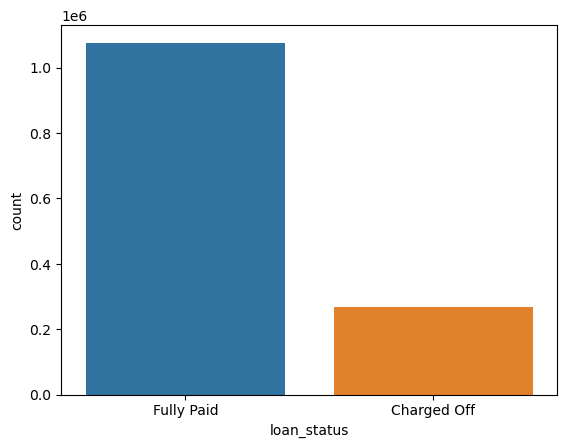

In [7]:
# Create a countplot to visualize the count of Fully Paid and Charged Off loan_status
sns.countplot(x='loan_status', data=df_filtered)

In [8]:
# Calculate the percentage of Charged Off lenders
percent_charged_off = (df_filtered['loan_status'].value_counts()['Charged Off']  / len(df_filtered)) * 100

percent_charged_off

19.962610848057324

The percentage of `Charged Off` lenders is around 20%. Assuming the decision to lend was decided by a human, this can mean that the probability of that person approving a loan to a lender who is proned to `Charging Off` is around 20%???

In [9]:
# Count the number of null values in each feature
null_counts = df_filtered.isnull().sum()

null_counts

id                             0
member_id                1345310
loan_amnt                      0
funded_amnt                    0
funded_amnt_inv                0
                          ...   
settlement_status        1312034
settlement_date          1312034
settlement_amount        1312034
settlement_percentage    1312034
settlement_term          1312034
Length: 151, dtype: int64

In [10]:
# Calculate the percentage of null values in each feature
null_percentage = (df_filtered.isnull().sum() / len(df_filtered)) * 100

null_percentage

id                         0.000000
member_id                100.000000
loan_amnt                  0.000000
funded_amnt                0.000000
funded_amnt_inv            0.000000
                            ...    
settlement_status         97.526518
settlement_date           97.526518
settlement_amount         97.526518
settlement_percentage     97.526518
settlement_term           97.526518
Length: 151, dtype: float64

In [11]:
# Define a certain null_percentage threshold
threshold = 20

# Find the columns that have nul_percentage higher than the threshold
columns_to_drop = null_percentage[null_percentage >= threshold].index

# Drop the columns with the high null_percentage from the dataframe
df_cleaned = df_filtered.drop(columns=columns_to_drop)

# Inspect the shape
df_cleaned.shape

(1345310, 93)

Dropping features with more than 20% null values left us with 93 features left to choose from. For the remaining feature selection, need to consult with someone with the necessary domain knowledge. 

In [12]:
remaining_features = df_cleaned.columns.tolist()

remaining_features

['id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'policy_code',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_open_to_buy',
 'bc_util',
 'ch

In [13]:
columns_to_retain = [
    'loan_amnt',
    'installment',
    'loan_status',
    'grade',
    'sub_grade',
    'term',
    'int_rate',
    'emp_title',
    'emp_length',
    'home_ownership',
    'annual_inc',
    'verification_status',
    'addr_state',
    'chargeoff_within_12_mths',
    'delinq_amnt',
    'application_type',
    'tot_coll_amt',
    'tot_cur_bal',
    'mort_acc',
    'open_acc',
    'fico_range_low',
    'fico_range_high',
    'total_acc'
]

len(columns_to_retain)

23

In [14]:
# Trim the remaining data to contain the selected features
df_trimmed = df_cleaned[columns_to_retain]

Text(0.5, 1.0, 'Correlation Heatmap')

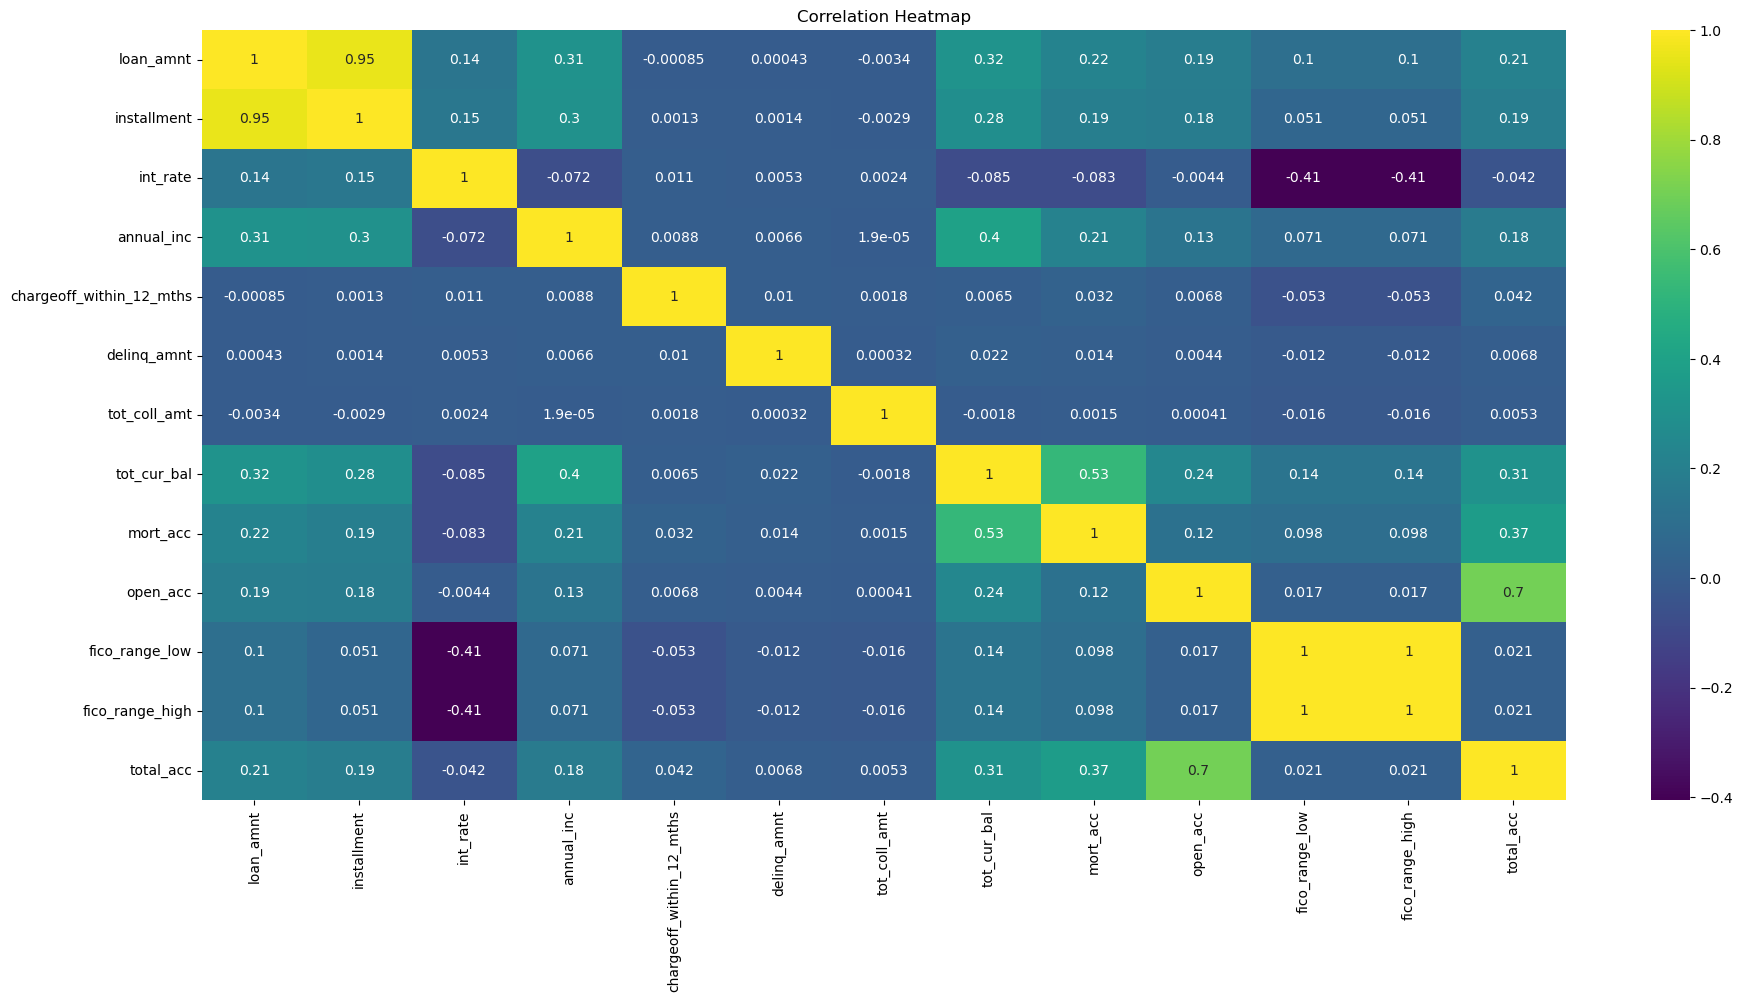

In [15]:
df_numerical = df_trimmed.select_dtypes(include=[int, float])

plt.figure(figsize=(22, 10))
sns.heatmap(df_numerical.corr(), annot=True, cmap='viridis')
plt.title('Correlation Heatmap')

In [16]:
df_trimmed.groupby('loan_status')[['loan_amnt']].describe().reset_index()

loan_status  loan_amnt                                                     \
                    count          mean          std    min     25%      50%   
0  Charged Off   268559.0  15565.055444  8814.560077  900.0  9000.0  14350.0   
1   Fully Paid  1076751.0  14134.369808  8669.028973  500.0  7500.0  12000.0   

                     
       75%      max  
0  20400.0  40000.0  
1  20000.0  40000.0

## Explorator Data Analysis (EDA)

In [17]:
df_trimmed.dtypes

loan_amnt                   float64
installment                 float64
loan_status                  object
grade                        object
sub_grade                    object
term                         object
int_rate                    float64
emp_title                    object
emp_length                   object
home_ownership               object
annual_inc                  float64
verification_status          object
addr_state                   object
chargeoff_within_12_mths    float64
delinq_amnt                 float64
application_type             object
tot_coll_amt                float64
tot_cur_bal                 float64
mort_acc                    float64
open_acc                    float64
fico_range_low              float64
fico_range_high             float64
total_acc                   float64
dtype: object

`addr_state`

/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Loan Count by State')

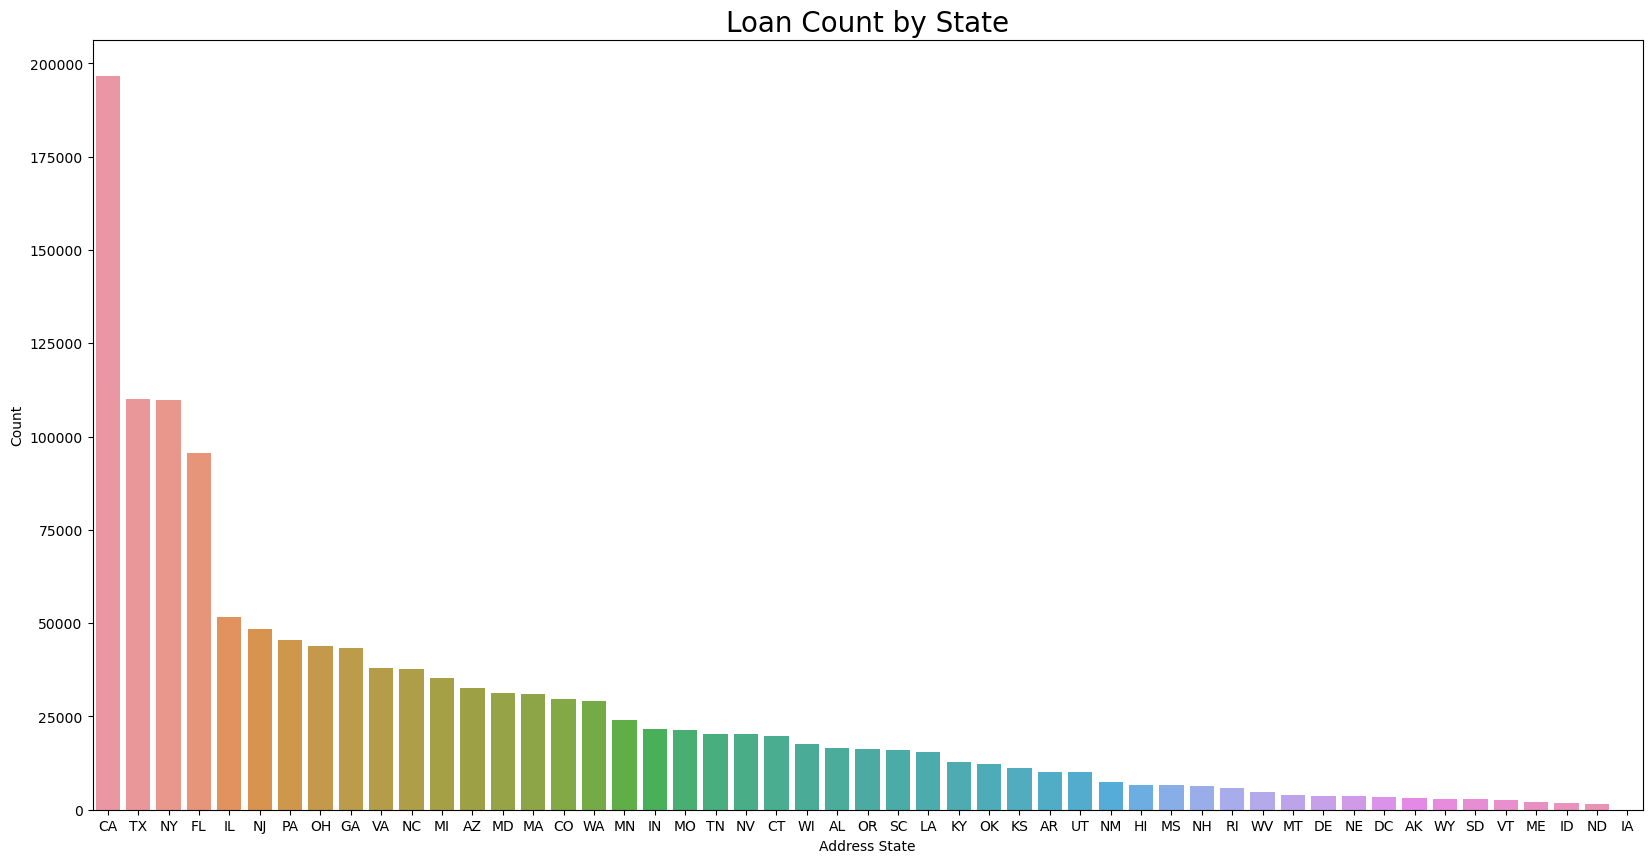

In [18]:
# Create loan count by state countplot
fig, ax = plt.subplots(figsize=(20,10))

order = df_trimmed['addr_state'].value_counts().index

sns.countplot(data=df_trimmed, x='addr_state', order=order)
ax.set(xlabel='Address State', ylabel='Count')
ax.set_title('Loan Count by State', size=20)

/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Loan Count by State')

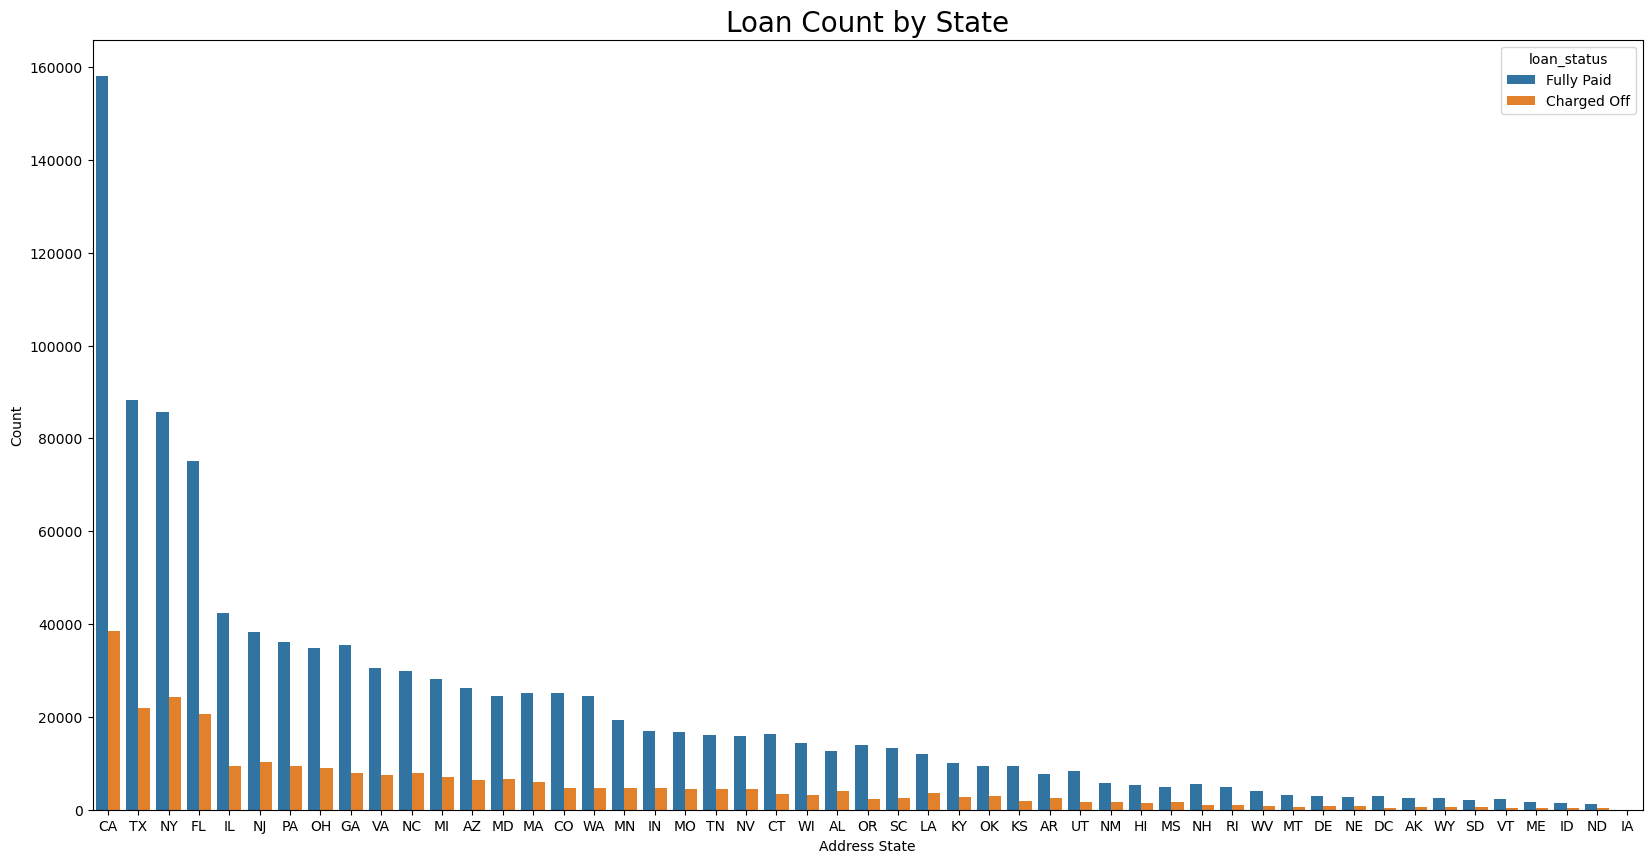

In [19]:
# Create loan count by state countplot
fig, ax = plt.subplots(figsize=(20,10))

order = df_trimmed['addr_state'].value_counts().index

sns.countplot(data=df_trimmed, x='addr_state', hue='loan_status', order=order)
ax.set(xlabel='Address State', ylabel='Count')
ax.set_title('Loan Count by State', size=20)

`grade`

/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Loan count by grade')

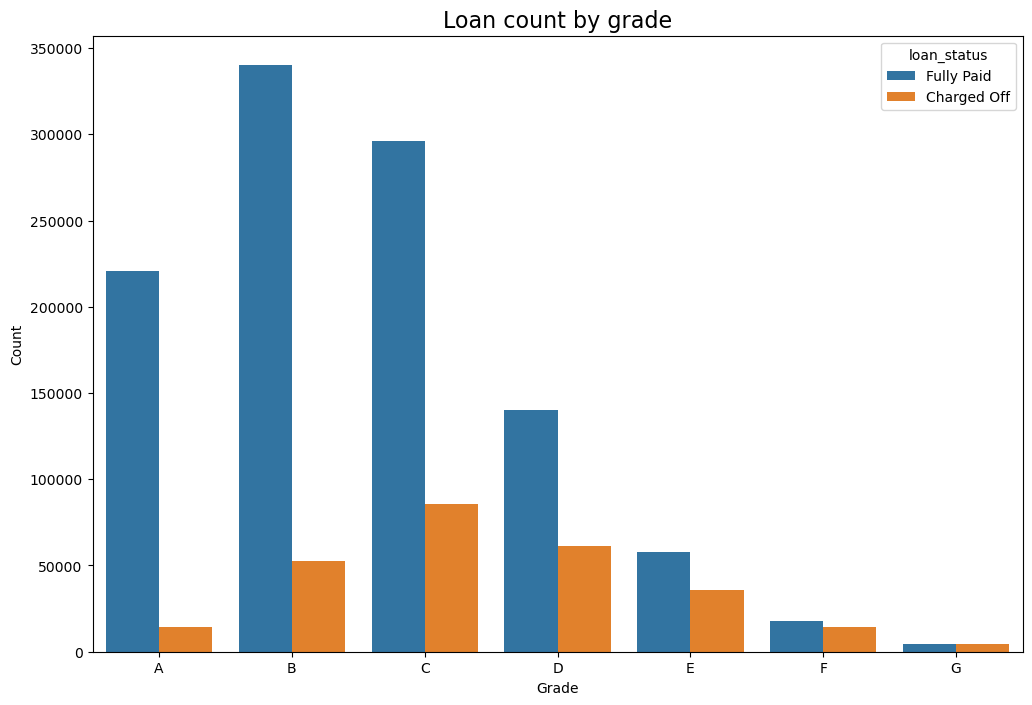

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))

grades = df_trimmed['grade'].unique()

grades = [grade for grade in grades if type(grade) != float]

order = sorted(grades) 

sns.countplot(data=df_trimmed, x='grade', hue='loan_status', order=order)

ax.set(xlabel='Grade', ylabel='Count')
ax.set_title('Loan count by grade', size=16)

We can observe that grade B, C, D, and D have some of the highest count of Charged Off occurences. However, grade F and G have the highest percentage of Charged Off occurences.

`sub_grade`

/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Loan count by sub grade')

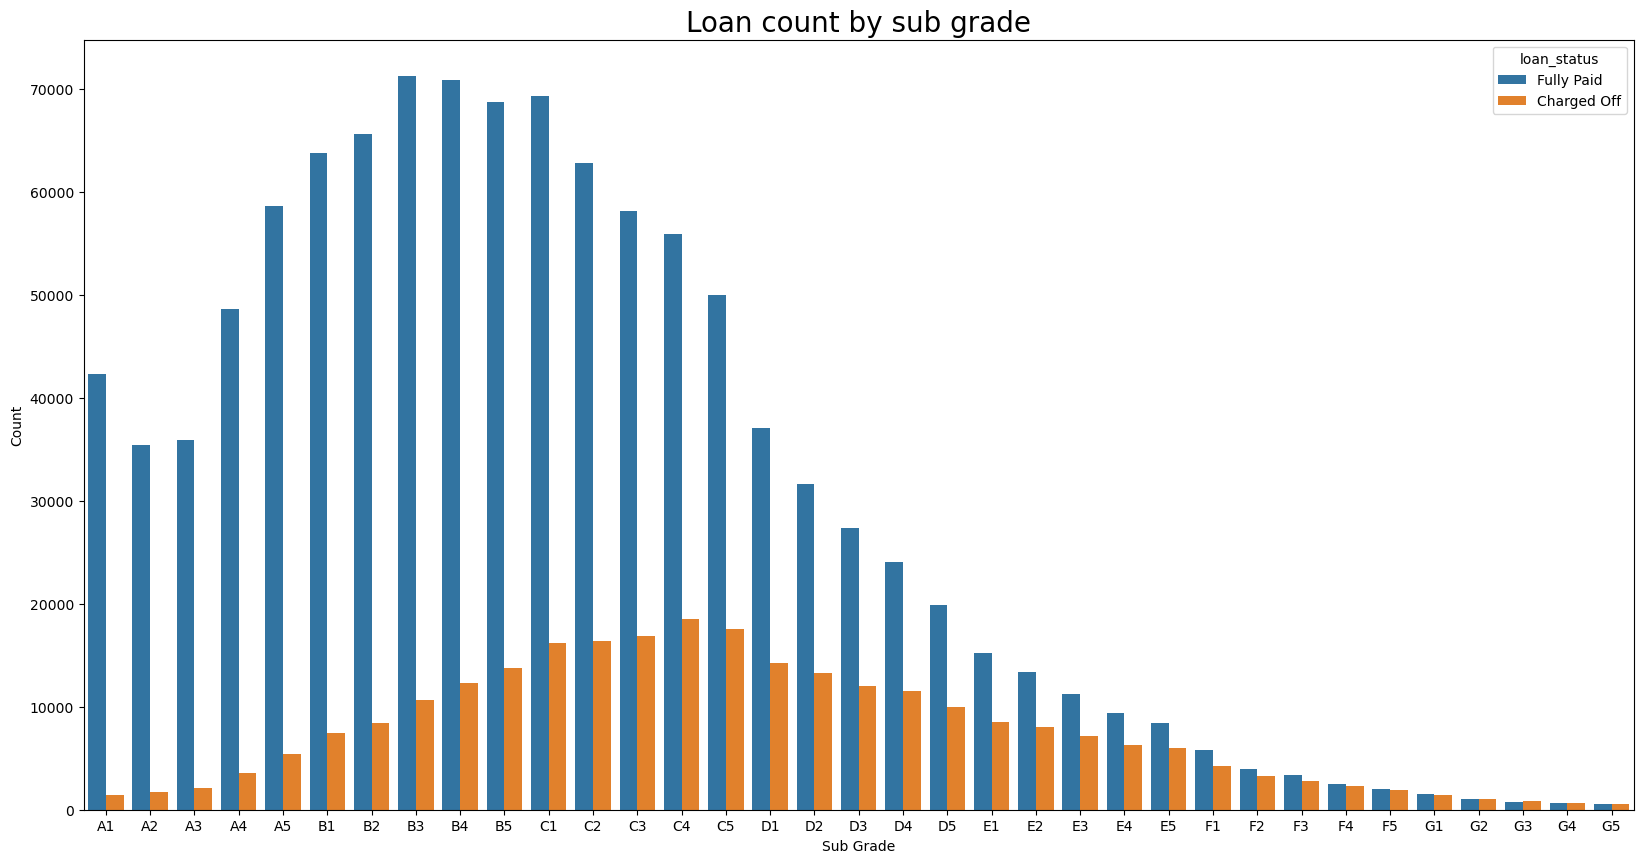

In [21]:
fig, ax = plt.subplots(figsize=(20,10))

order = sorted(df_trimmed['sub_grade'].unique())

sns.countplot(data=df_trimmed, x='sub_grade', hue='loan_status', order=order)

ax.set(xlabel='Sub Grade', ylabel='Count')
ax.set_title('Loan count by sub grade', size=20)

`emp_length`

/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Loan count by employment length')

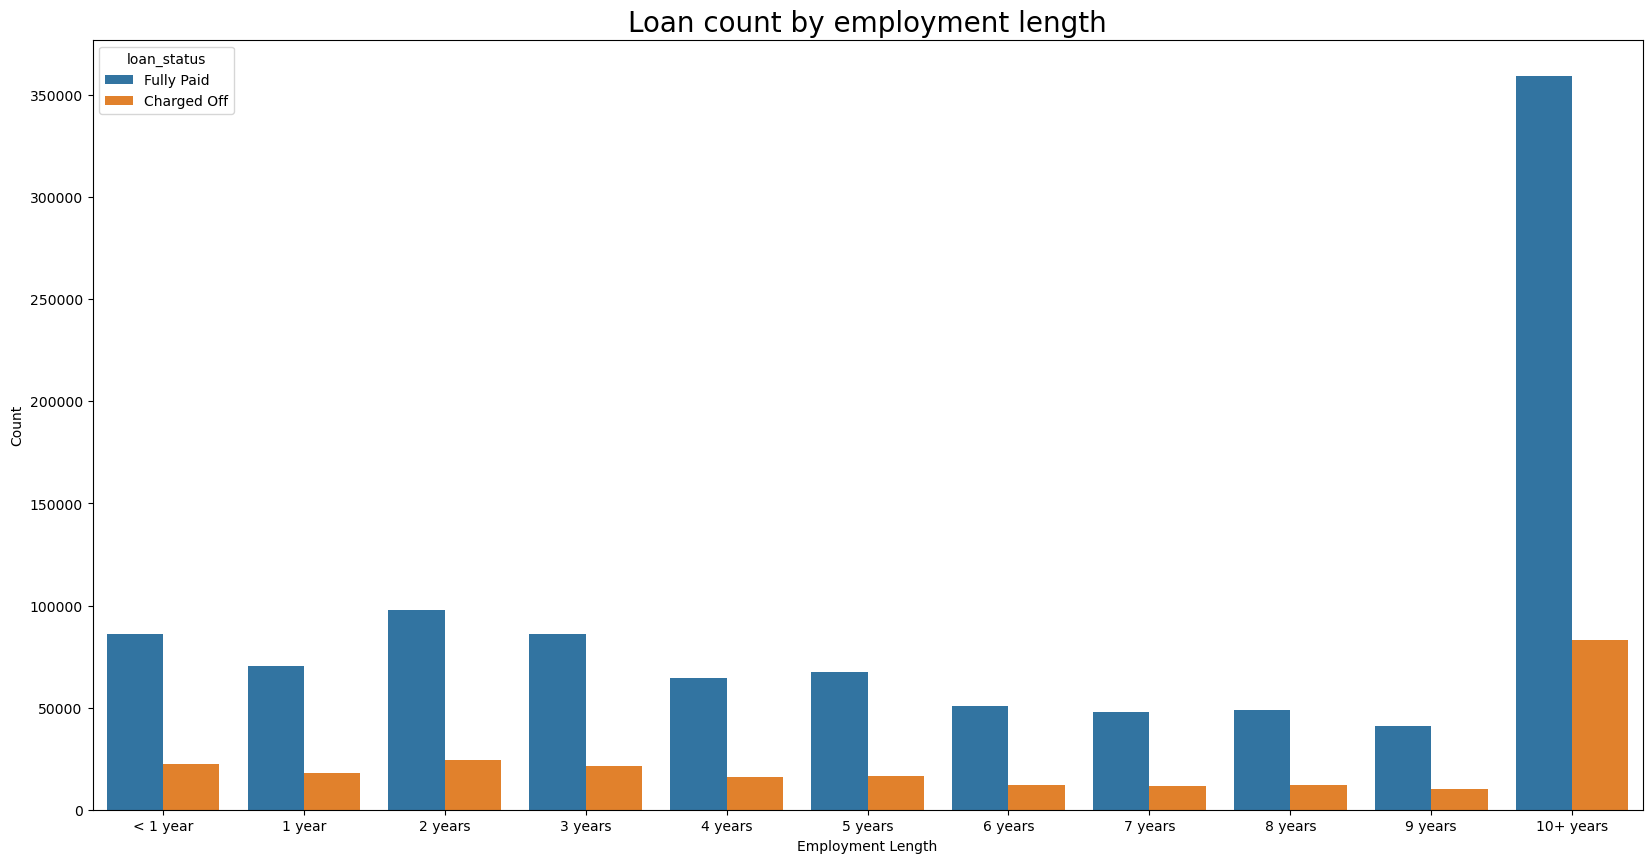

In [22]:
fig, ax = plt.subplots(figsize=(20,10))

order = [
    '< 1 year',
    '1 year',
    '2 years',
    '3 years',
    '4 years',
    '5 years',
    '6 years',
    '7 years',
    '8 years',
    '9 years',
    '10+ years'
]

sns.countplot(data=df_trimmed, x='emp_length', hue='loan_status', order=order)

ax.set(xlabel='Employment Length', ylabel='Count')
ax.set_title('Loan count by employment length', size=20)

This countplot does not paint a real picture of the percentage of Charged Off loans in relation with Paid Off loans. That what we want to see the significance of this feature, let's create a table that represents that percentage

In [23]:

df_co = df_trimmed[df['loan_status'] == 'Charged Off'].groupby('emp_length').count()[['loan_status']]

df_fp = df_trimmed[df['loan_status'] == 'Fully Paid'].groupby('emp_length').count()[['loan_status']]

percent_co = df_co / df_fp * 100

percent_co.rename(columns={'loan_status': 'Percentage Charged Off Loans'}).reset_index()

/var/folders/16/cclqjy7n72d14ngr0ys9zwjr0000gn/T/ipykernel_14628/2341890951.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_co = df_trimmed[df['loan_status'] == 'Charged Off'].groupby('emp_length').count()[['loan_status']]
/var/folders/16/cclqjy7n72d14ngr0ys9zwjr0000gn/T/ipykernel_14628/2341890951.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fp = df_trimmed[df['loan_status'] == 'Fully Paid'].groupby('emp_length').count()[['loan_status']]


,emp_length,Percentage Charged Off Loans
0,1 year,25.887675
1,10+ years,23.126507
2,2 years,24.699628
3,3 years,24.951516
4,4 years,24.591685
5,5 years,24.379610
6,6 years,23.995414
7,7 years,24.206316
8,8 years,24.896607
9,9 years,24.845588


The percentage of Charged Off loans look pretty much similar across employment length. We will remove this feature in data pre-processing section.

`emp_title`

In [24]:
# Display the unique employment title
df_trimmed['emp_title'].value_counts()

emp_title
Teacher                          21268
Manager                          19470
Owner                            10302
Registered Nurse                  8774
RN                                8522
                                 ...  
CSR. SR                              1
Auto body prepper                    1
Software engineer supervisor         1
Ins Adjuster                         1
Exec Dir Internal Audit              1
Name: count, Length: 378353, dtype: int64

There are 378,353 unique employment titles. This might be way too much for any further processing, remove this feature in data pre-processing "section.

`term`

/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Loan Count By Term')

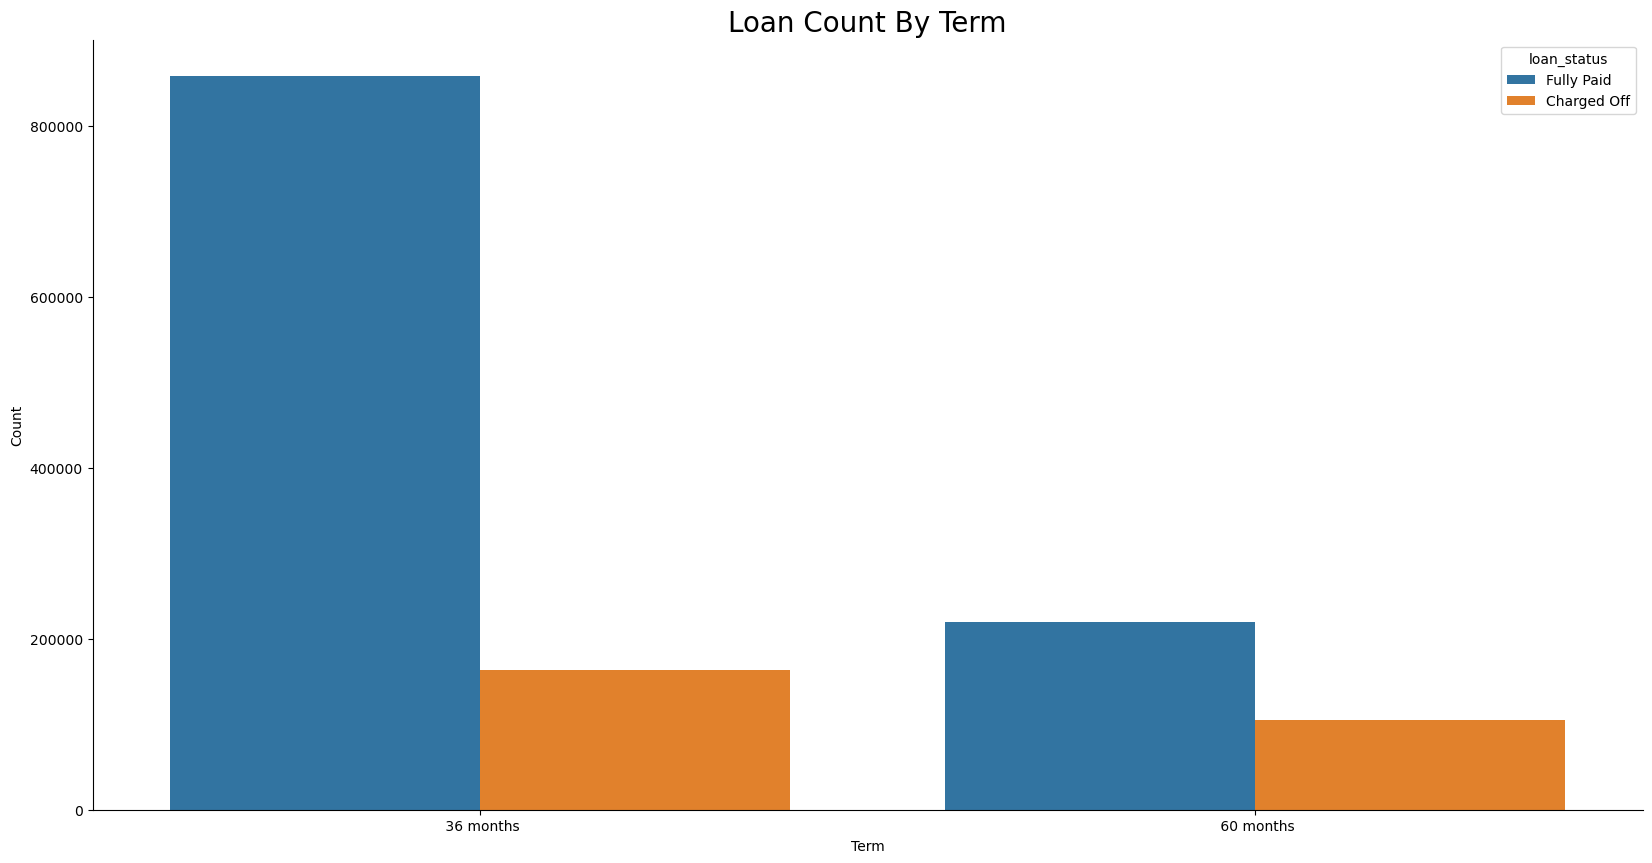

In [25]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.despine()
order = sorted(df_trimmed['term'].unique())
sns.countplot(data=df_trimmed, x='term', hue='loan_status', order=order)

ax.set(xlabel='Term', ylabel='Count')
ax.set_title('Loan Count By Term', size=20)

`home_ownership`

In [26]:
# List home ownership unique values
unique_home_ownership = df['home_ownership'].dropna().unique().tolist()

/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

<Axes: title={'center': 'Ownership - Last values zoom-in'}, xlabel='home_ownership', ylabel='count'>

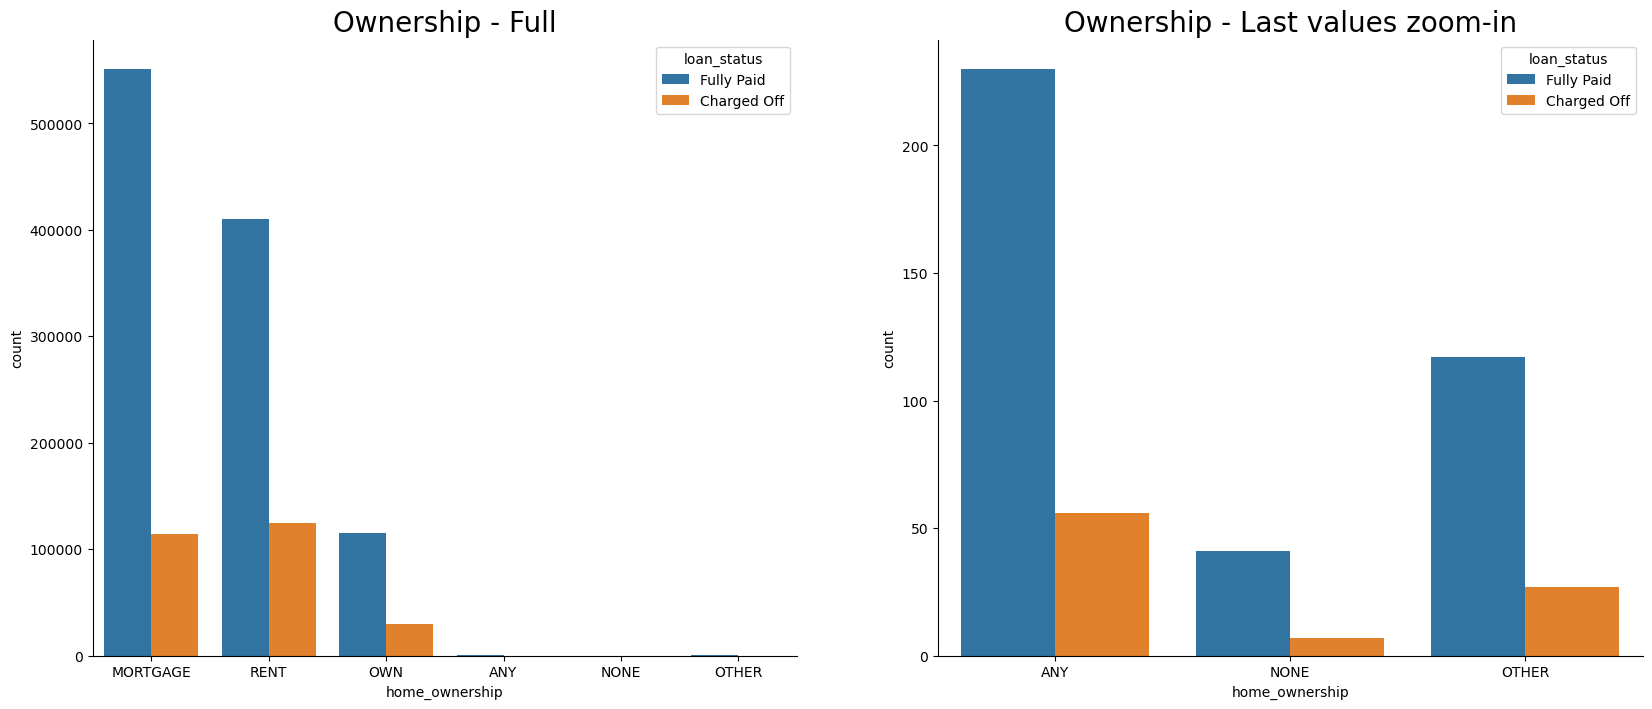

In [27]:
fig, ax =plt.subplots(1,2,figsize=(20,8))

sns.despine()

ax[0].tick_params(axis='x', labelrotation=0)
ax[0].set(xlabel='Ownership status', ylabel='')
ax[0].set_title('Ownership - Full', size=20)
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].set(xlabel='Ownership status', ylabel='')
ax[1].set_title('Ownership - Last values zoom-in', size=20)

sns.countplot(data=df_trimmed,x="home_ownership",hue="loan_status",ax=ax[0])
sns.countplot(data=df_trimmed,x="home_ownership",hue="loan_status",order=["ANY","NONE","OTHER"],ax=ax[1])

`verification_status`

In [28]:
# Inspect unique values
unique_vef_stat = df_trimmed['verification_status'].unique()

unique_vef_stat

array(['Not Verified', 'Source Verified', 'Verified'], dtype=object)

/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

<Axes: xlabel='verification_status', ylabel='count'>

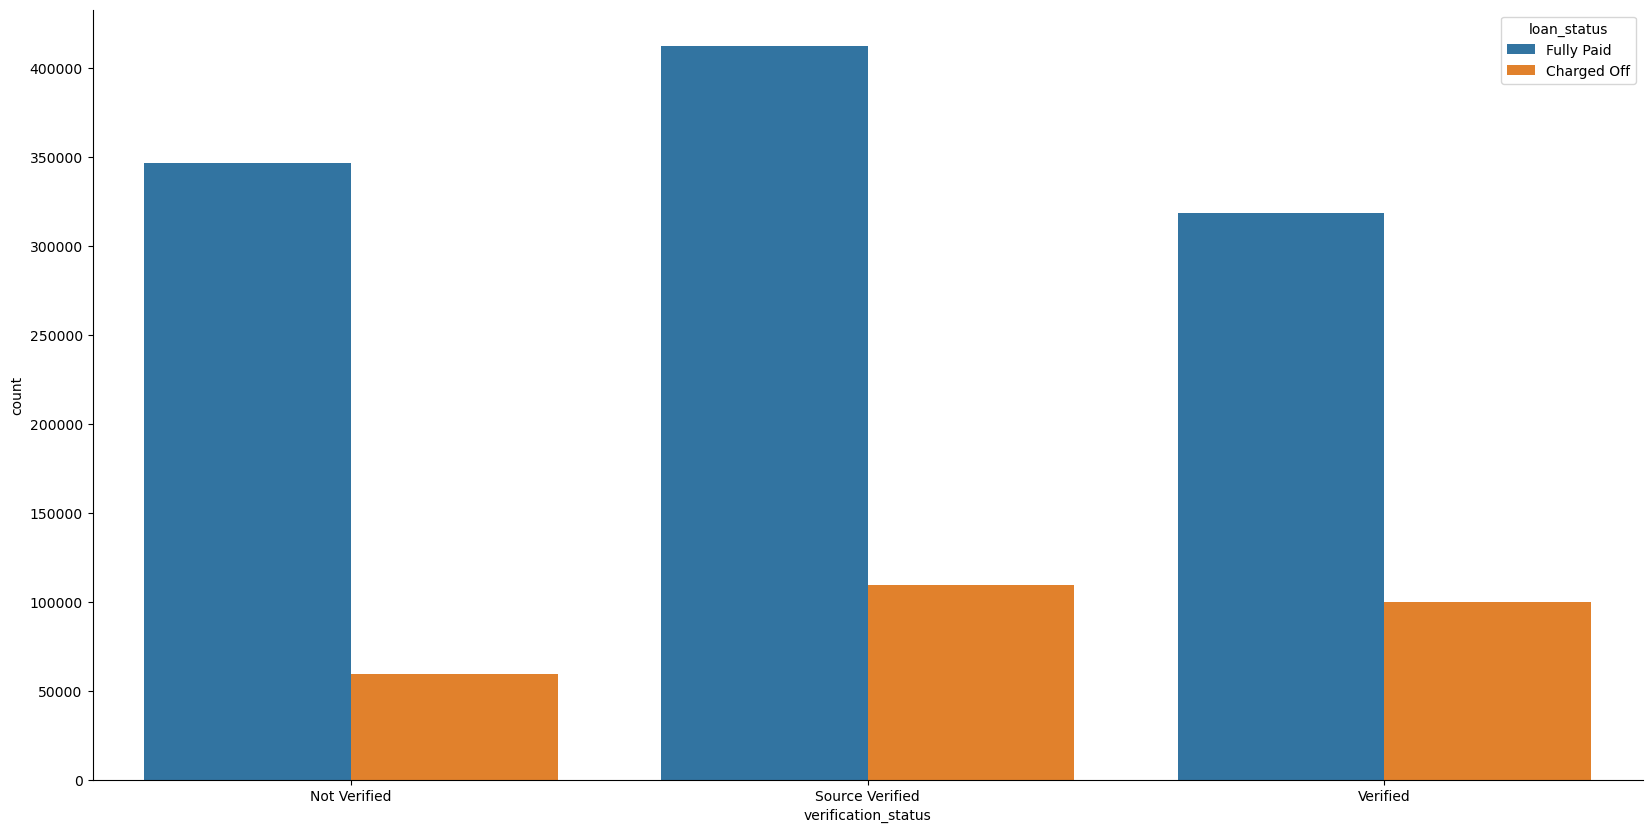

In [29]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.despine()
sns.countplot(data=df_trimmed, x='verification_status', hue='loan_status')


This the percentage of Charged Off status vs Fully Paid looks quite similar here. Let's create a table to inspect our speculation.

In [30]:
df_co_verf = df_trimmed[df['loan_status'] == 'Charged Off'].groupby('verification_status').count()[['loan_status']]

df_fp_verf = df_trimmed[df['loan_status'] == 'Fully Paid'].groupby('verification_status').count()[['loan_status']]

percent_co = df_co_verf / df_fp_verf * 100

percent_co.rename(columns={'verification_status': 'Percentage Charged Off Loans'}).reset_index()

/var/folders/16/cclqjy7n72d14ngr0ys9zwjr0000gn/T/ipykernel_14628/3147461750.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_co_verf = df_trimmed[df['loan_status'] == 'Charged Off'].groupby('verification_status').count()[['loan_status']]
/var/folders/16/cclqjy7n72d14ngr0ys9zwjr0000gn/T/ipykernel_14628/3147461750.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fp_verf = df_trimmed[df['loan_status'] == 'Fully Paid'].groupby('verification_status').count()[['loan_status']]


,verification_status,loan_status
0,Not Verified,17.198396
1,Source Verified,26.509983
2,Verified,31.327540


`application_type`

In [31]:
# Inspect unique values
unique_app_types = df_trimmed['application_type'].unique()

unique_app_types

array(['Individual', 'Joint App'], dtype=object)

/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

<Axes: xlabel='application_type', ylabel='count'>

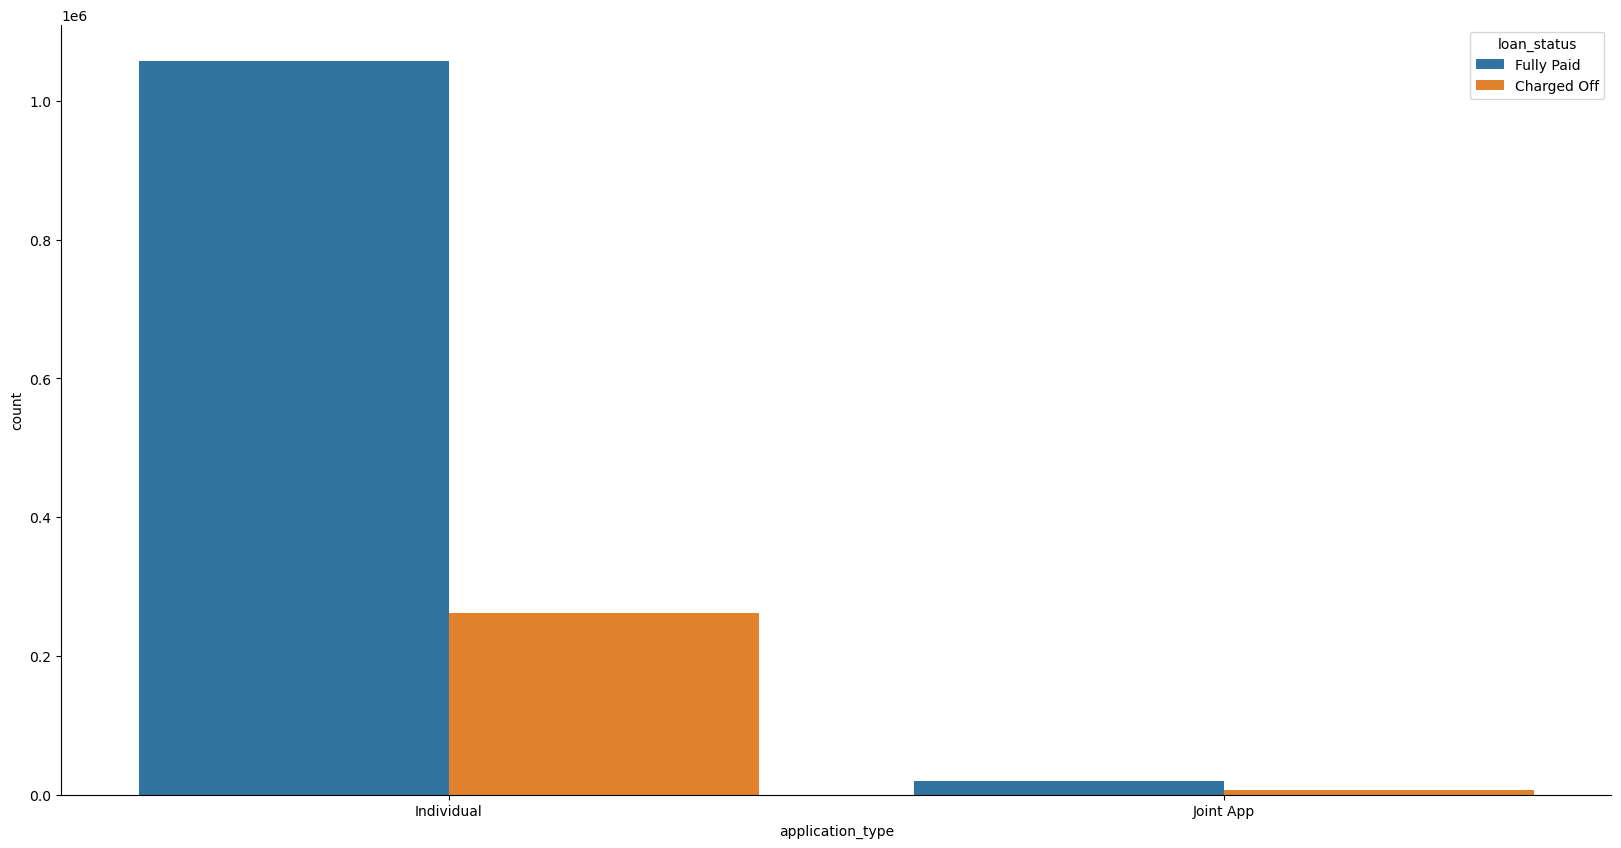

In [32]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.despine()
sns.countplot(data=df_trimmed, x='application_type', hue='loan_status')

In [33]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

`loan_amnt`

/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

[Text(0.5, 0, 'Loan Status'), Text(0, 0.5, 'Amount in USD')]

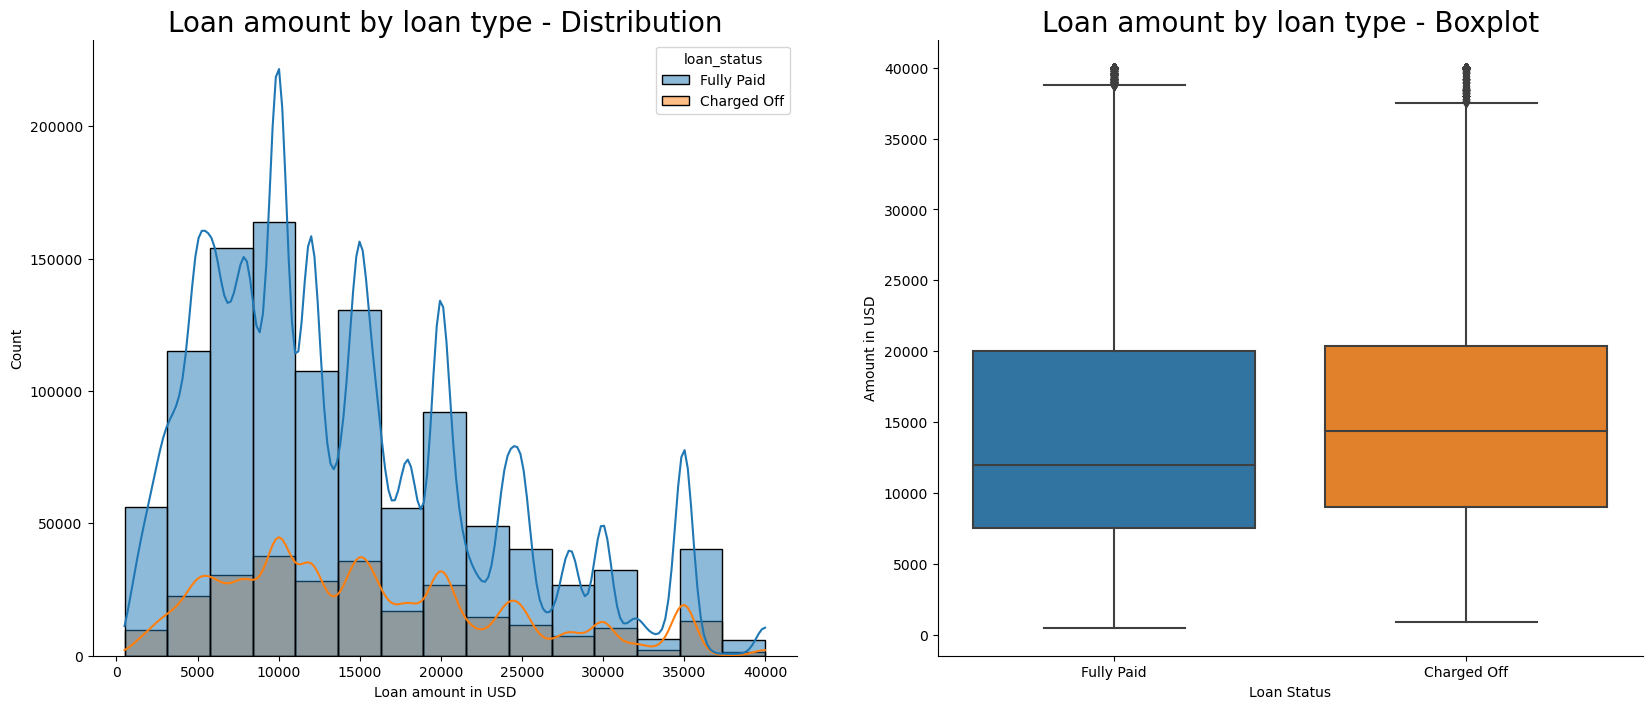

In [34]:
# Loan amount count by loan status

fig, ax =plt.subplots(1,2,figsize=(20,8))

sns.despine()

ax[0].tick_params(axis='x', labelrotation=0)
ax[0].set(xlabel='Loan amount in USD', ylabel='')
ax[0].set_title('Loan amount by loan type - Distribution', size=20)
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].set_title('Loan amount by loan type - Boxplot', size=20)

sns.histplot(data=df_trimmed,x="loan_amnt",hue="loan_status",bins=15,
             kde=True,ax=ax[0])
sns.boxplot(data=df_trimmed,x="loan_status",y="loan_amnt",ax=ax[1]).set(xlabel='Loan Status',
                                                                     ylabel='Amount in USD')

`installment`

/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

[Text(0.5, 0, 'Loan Status'), Text(0, 0.5, 'Amount in USD')]

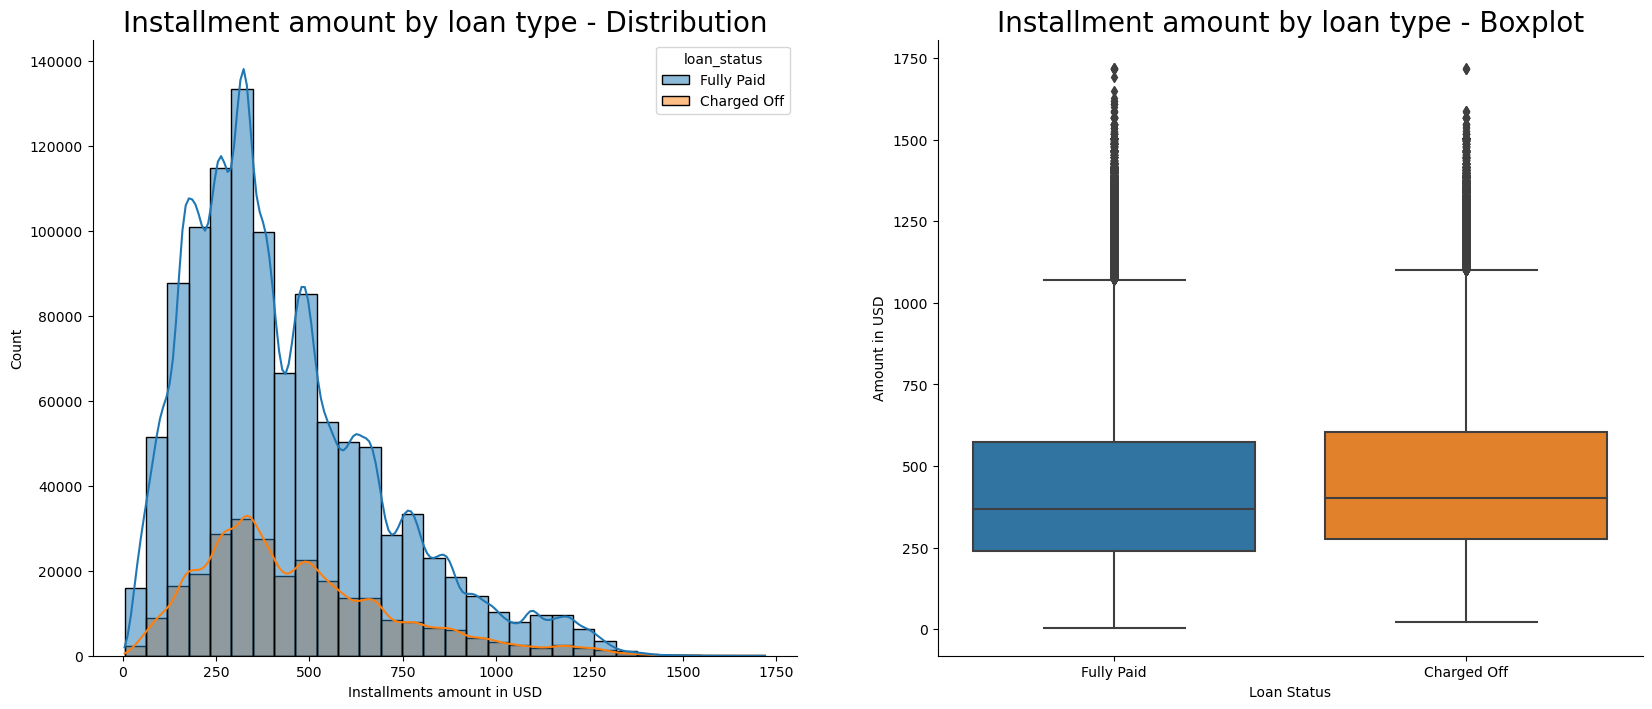

In [35]:
# Installment amount count by loan status

fig, ax =plt.subplots(1,2,figsize=(20,8))

sns.despine()

ax[0].tick_params(axis='x', labelrotation=0)
ax[0].set(xlabel='Installments amount in USD', ylabel='')
ax[0].set_title('Installment amount by loan type - Distribution', size=20)
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].set_title('Installment amount by loan type - Boxplot', size=20)


sns.histplot(data=df_trimmed,x="installment",hue="loan_status",bins=30,
             kde=True,ax=ax[0])
sns.boxplot(data=df_trimmed,x="loan_status",y="installment",ax=ax[1]).set(xlabel='Loan Status',
                                                                       ylabel='Amount in USD')

`int_rate`

/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

[Text(0.5, 0, 'Loan Status'), Text(0, 0.5, 'Interest rate in %')]

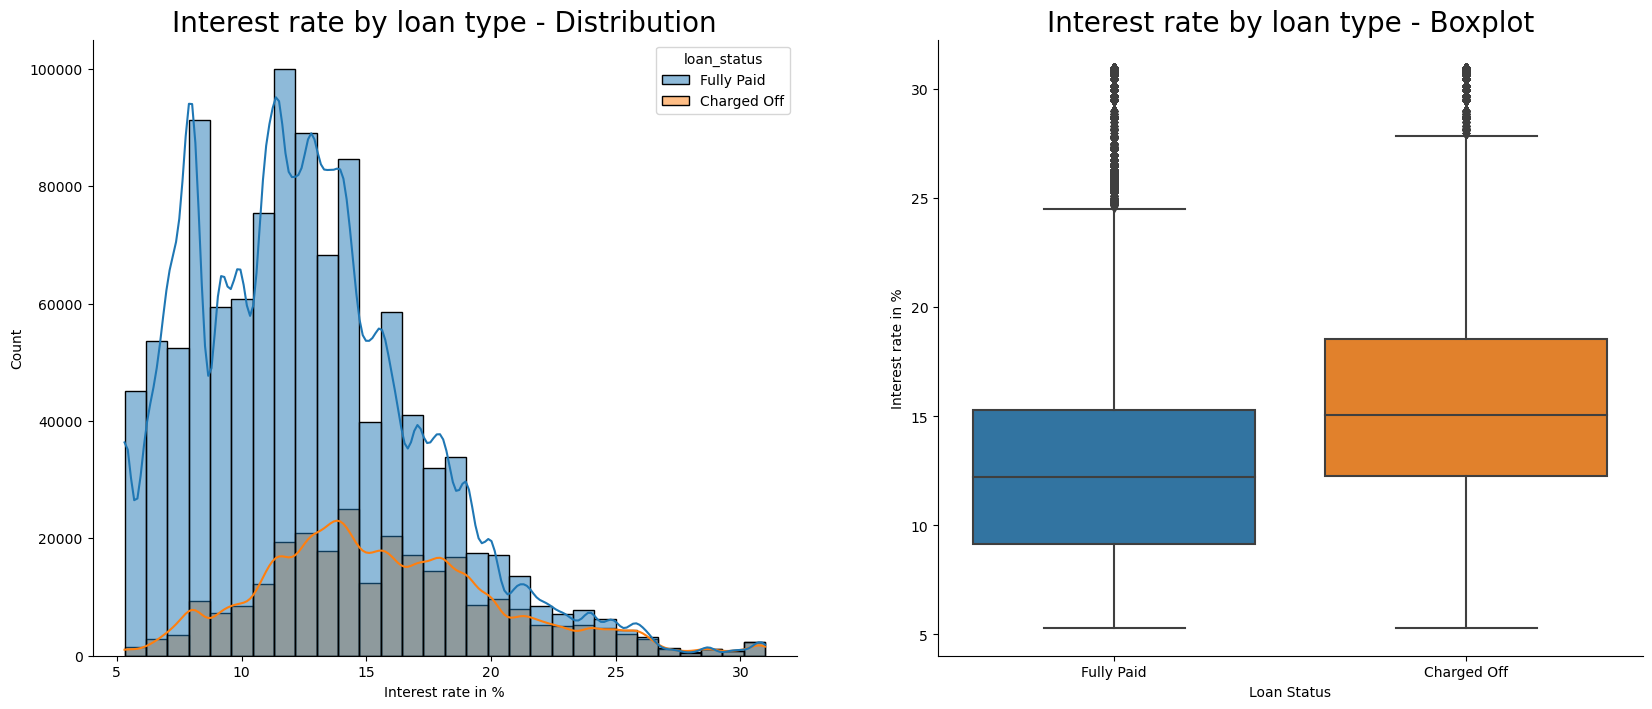

In [36]:
# Interest rate count by loan status

fig, ax =plt.subplots(1,2,figsize=(20,8))

sns.despine()

ax[0].tick_params(axis='x', labelrotation=0)
ax[0].set(xlabel='Interest rate in %', ylabel='')
ax[0].set_title('Interest rate by loan type - Distribution', size=20)
ax[1].tick_params(axis='x', labelrotation=0)
ax[1].set_title('Interest rate by loan type - Boxplot', size=20)


sns.histplot(data=df_trimmed,x="int_rate",hue="loan_status",bins=30,
             kde=True,ax=ax[0])

sns.boxplot(data=df_trimmed,x="loan_status",y="int_rate",ax=ax[1]).set(xlabel='Loan Status',
                                                                    ylabel='Interest rate in %')

`annual_inc`

/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

[Text(0.5, 0, 'Loan Status'), Text(0, 0.5, 'Annual inc. in USD')]

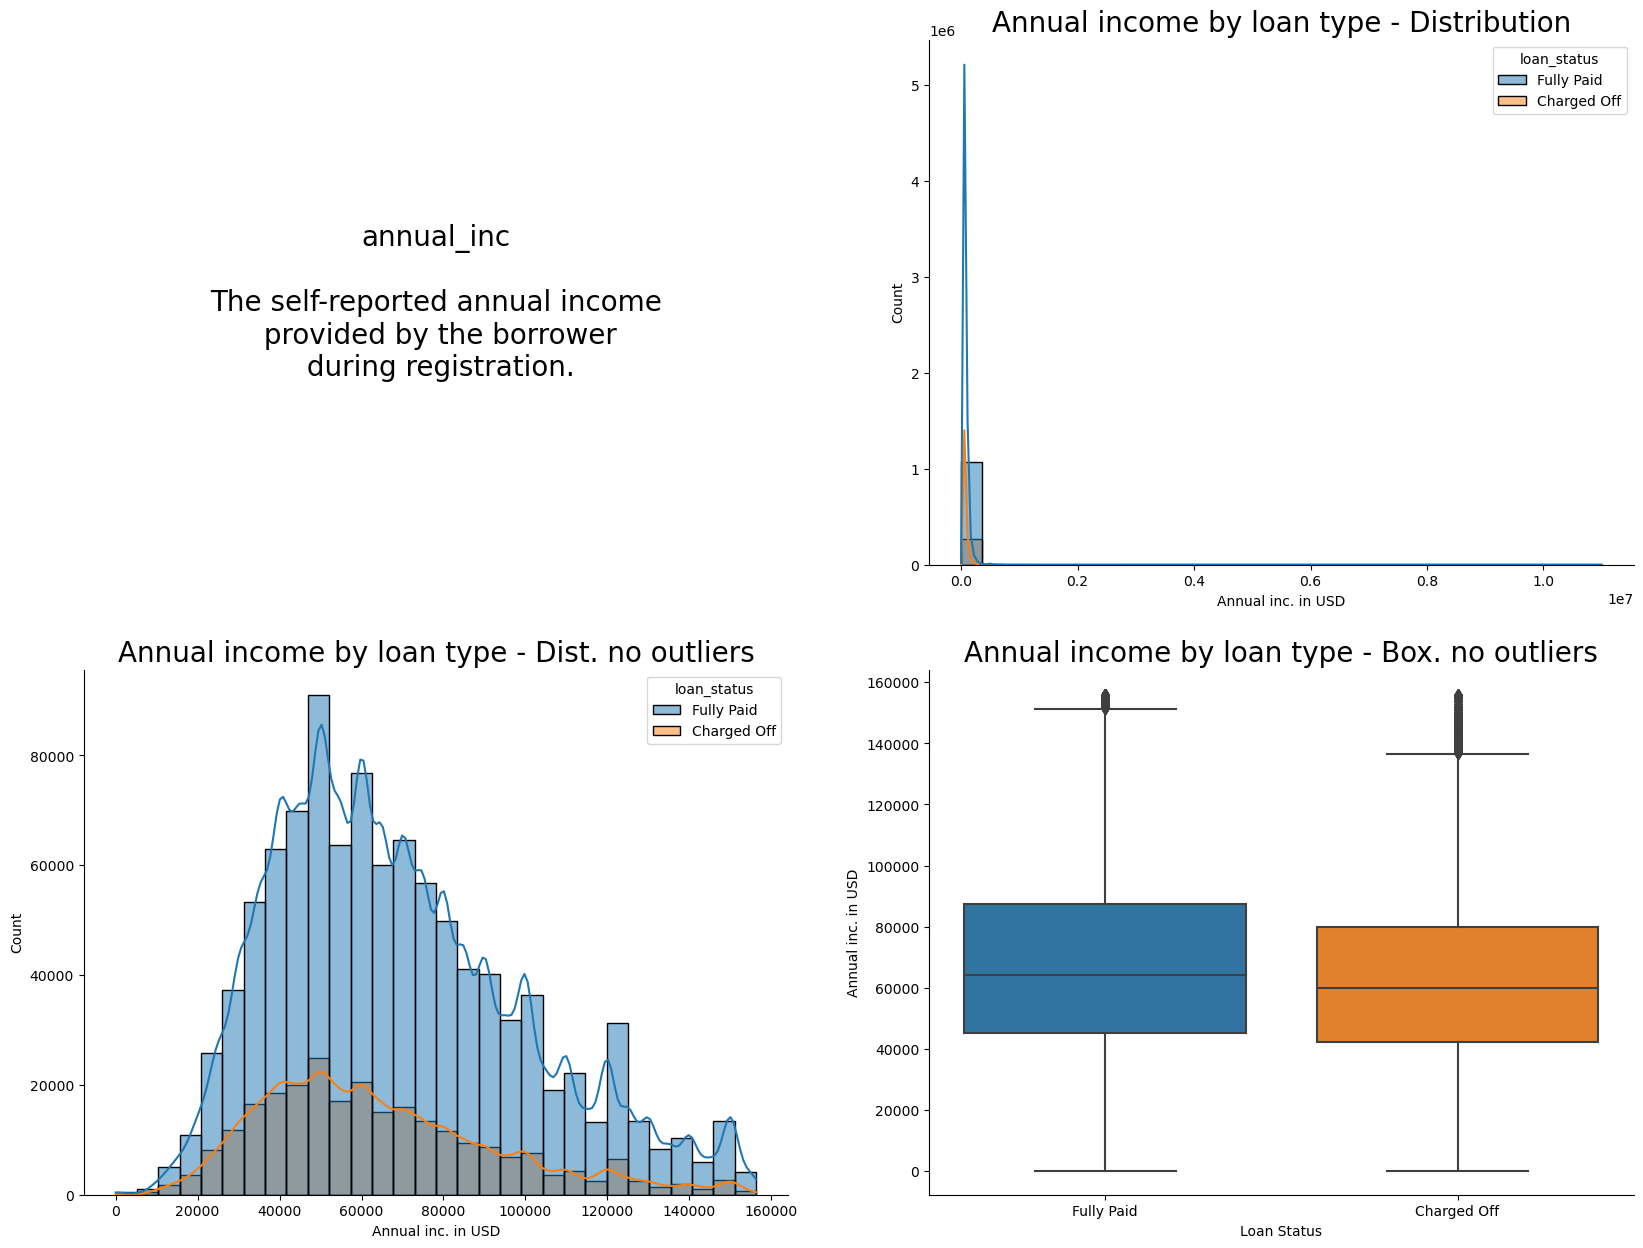

In [37]:
fig, ax =plt.subplots(2,2,figsize=(20,15))

sns.despine()

ax0 = fig.add_subplot(ax[0,0])
ax0.spines[:].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,"annual_inc\n\nThe self-reported annual income\n provided by the borrower\n during registration.",
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=20,
         color="#000000")

ax[0,1].tick_params(axis='x', labelrotation=0)
ax[0,1].set(xlabel='Annual inc. in USD', ylabel='')
ax[0,1].set_title('Annual income by loan type - Distribution', size=20)
ax[1,0].tick_params(axis='x', labelrotation=0)
ax[1,0].set(xlabel='Annual inc. in USD', ylabel='')
ax[1,0].set_title('Annual income by loan type - Dist. no outliers', size=20)
ax[1,1].set_title('Annual income by loan type - Box. no outliers', size=20)

sns.histplot(data=df_trimmed,x="annual_inc",hue="loan_status",bins=30,
             kde=True,ax=ax[0,1])

# Temporaly removing outliers to get a better visualization
annual_inc=remove_outlier(df_trimmed, "annual_inc")

sns.histplot(data=annual_inc,x="annual_inc",hue="loan_status",bins=30,
             kde=True, ax=ax[1,0])

sns.boxplot(data=annual_inc,x="loan_status",y="annual_inc",ax=ax[1,1]).set(xlabel='Loan Status',
                                                                           ylabel='Annual inc. in USD')

`tot_cur_bal`

/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

[Text(0.5, 0, 'Charge Off Within 12 Months'),
 Text(0, 0.5, 'Total current balance of all accounts in USD')]

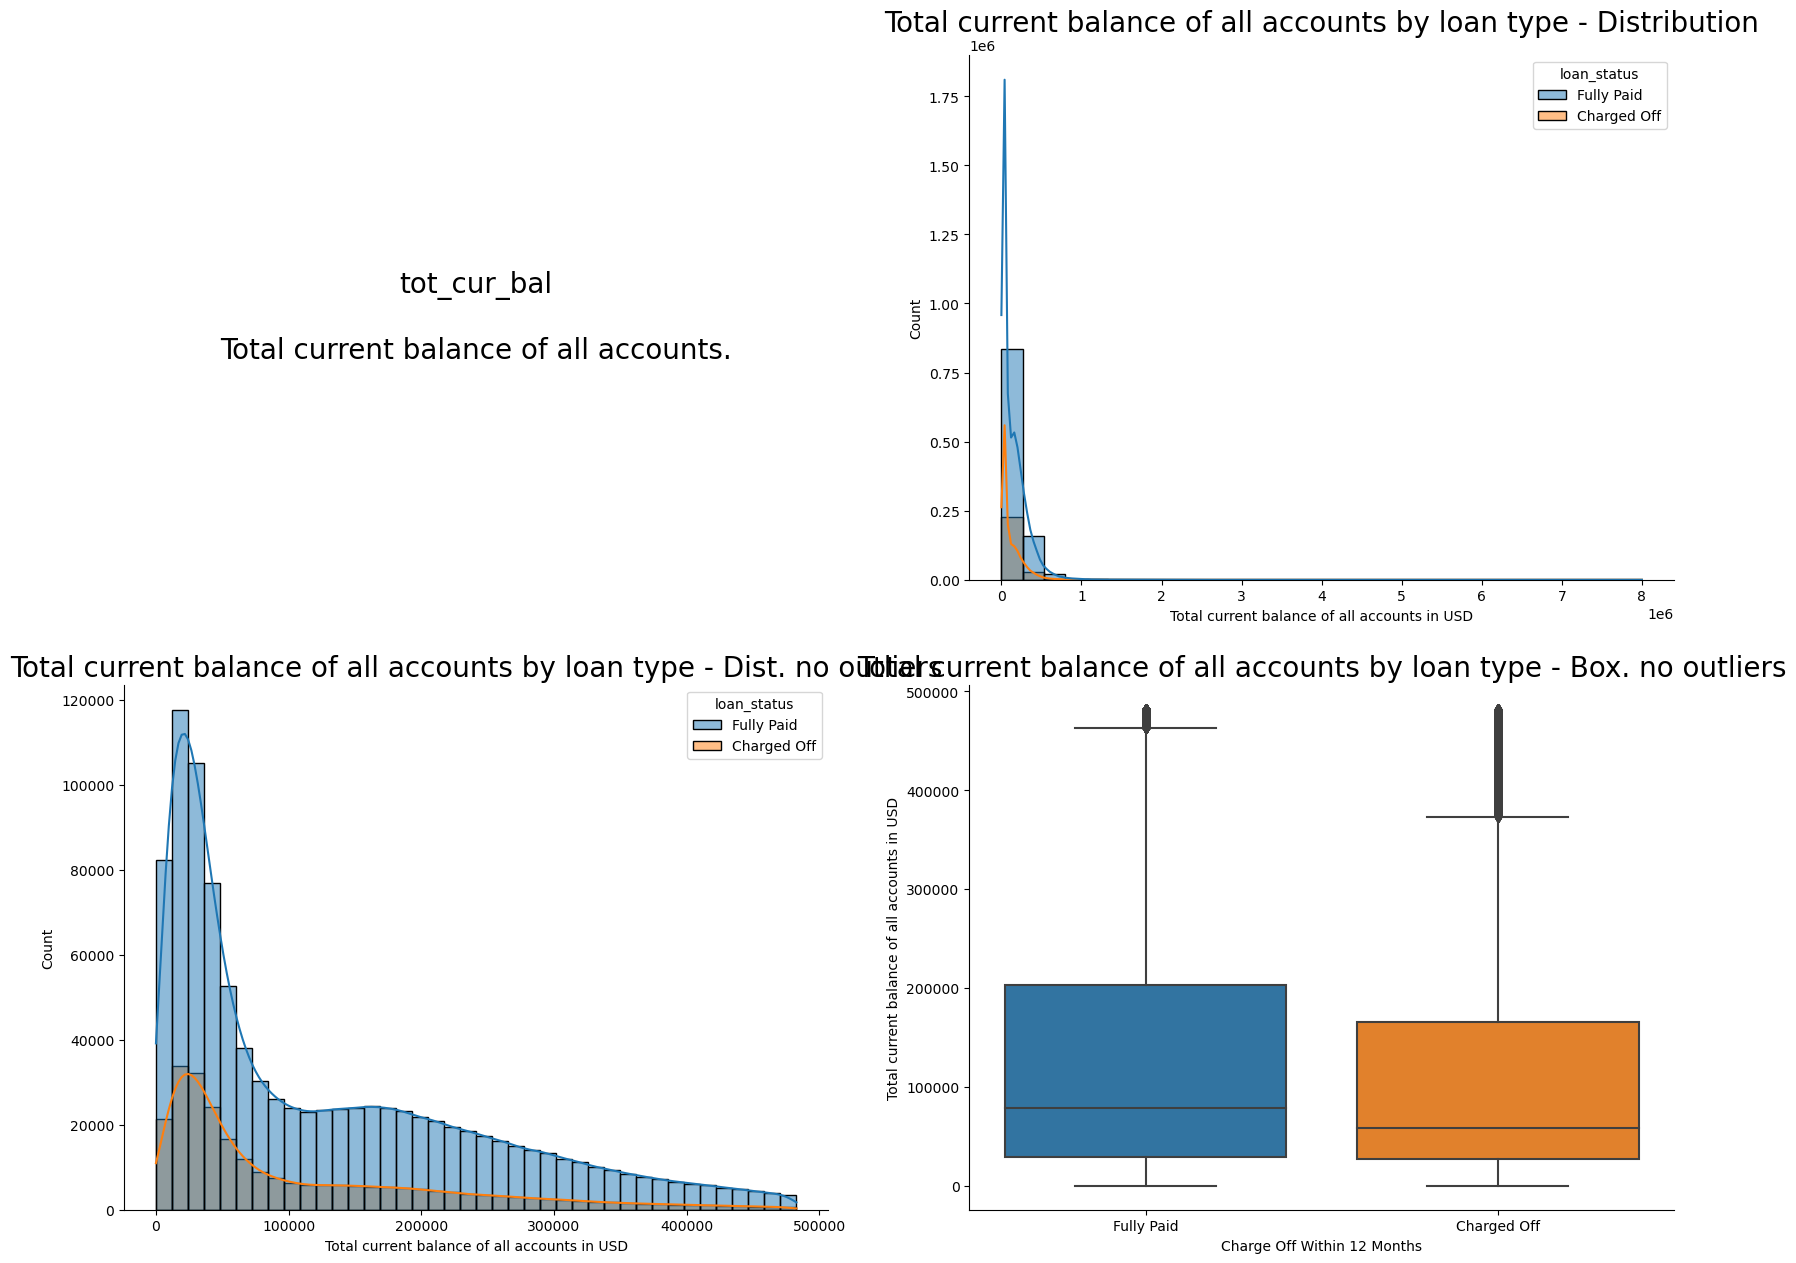

In [38]:
fig, ax =plt.subplots(2,2,figsize=(20,15))

sns.despine()

ax0 = fig.add_subplot(ax[0,0])
ax0.spines[:].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,"tot_cur_bal\n\nTotal current balance of all accounts.",
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=20,
         color="#000000")

ax[0,1].tick_params(axis='x', labelrotation=0)
ax[0,1].set(xlabel='Total current balance of all accounts in USD', ylabel='')
ax[0,1].set_title('Total current balance of all accounts by loan type - Distribution', size=20)
ax[1,0].tick_params(axis='x', labelrotation=0)
ax[1,0].set(xlabel='Total current balance of all accounts in USD', ylabel='')
ax[1,0].set_title('Total current balance of all accounts by loan type - Dist. no outliers', size=20)
ax[1,1].set_title('Total current balance of all accounts by loan type - Box. no outliers', size=20)

sns.histplot(data=df_trimmed,x="tot_cur_bal",hue="loan_status",bins=30,
             kde=True,ax=ax[0,1])

# Temporaly removing outliers to get a better visualization
annual_inc=remove_outlier(df_trimmed, "tot_cur_bal")

sns.histplot(data=annual_inc,x="tot_cur_bal",hue="loan_status",bins=40,
             kde=True, ax=ax[1,0])

sns.boxplot(data=annual_inc,x="loan_status",y="tot_cur_bal",ax=ax[1,1]).set(xlabel='Charge Off Within 12 Months',
                                                                           ylabel='Total current balance of all accounts in USD')

`mort_acc`

/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

[Text(0.5, 0, 'Loan Status'), Text(0, 0.5, '# of mortage accounts')]

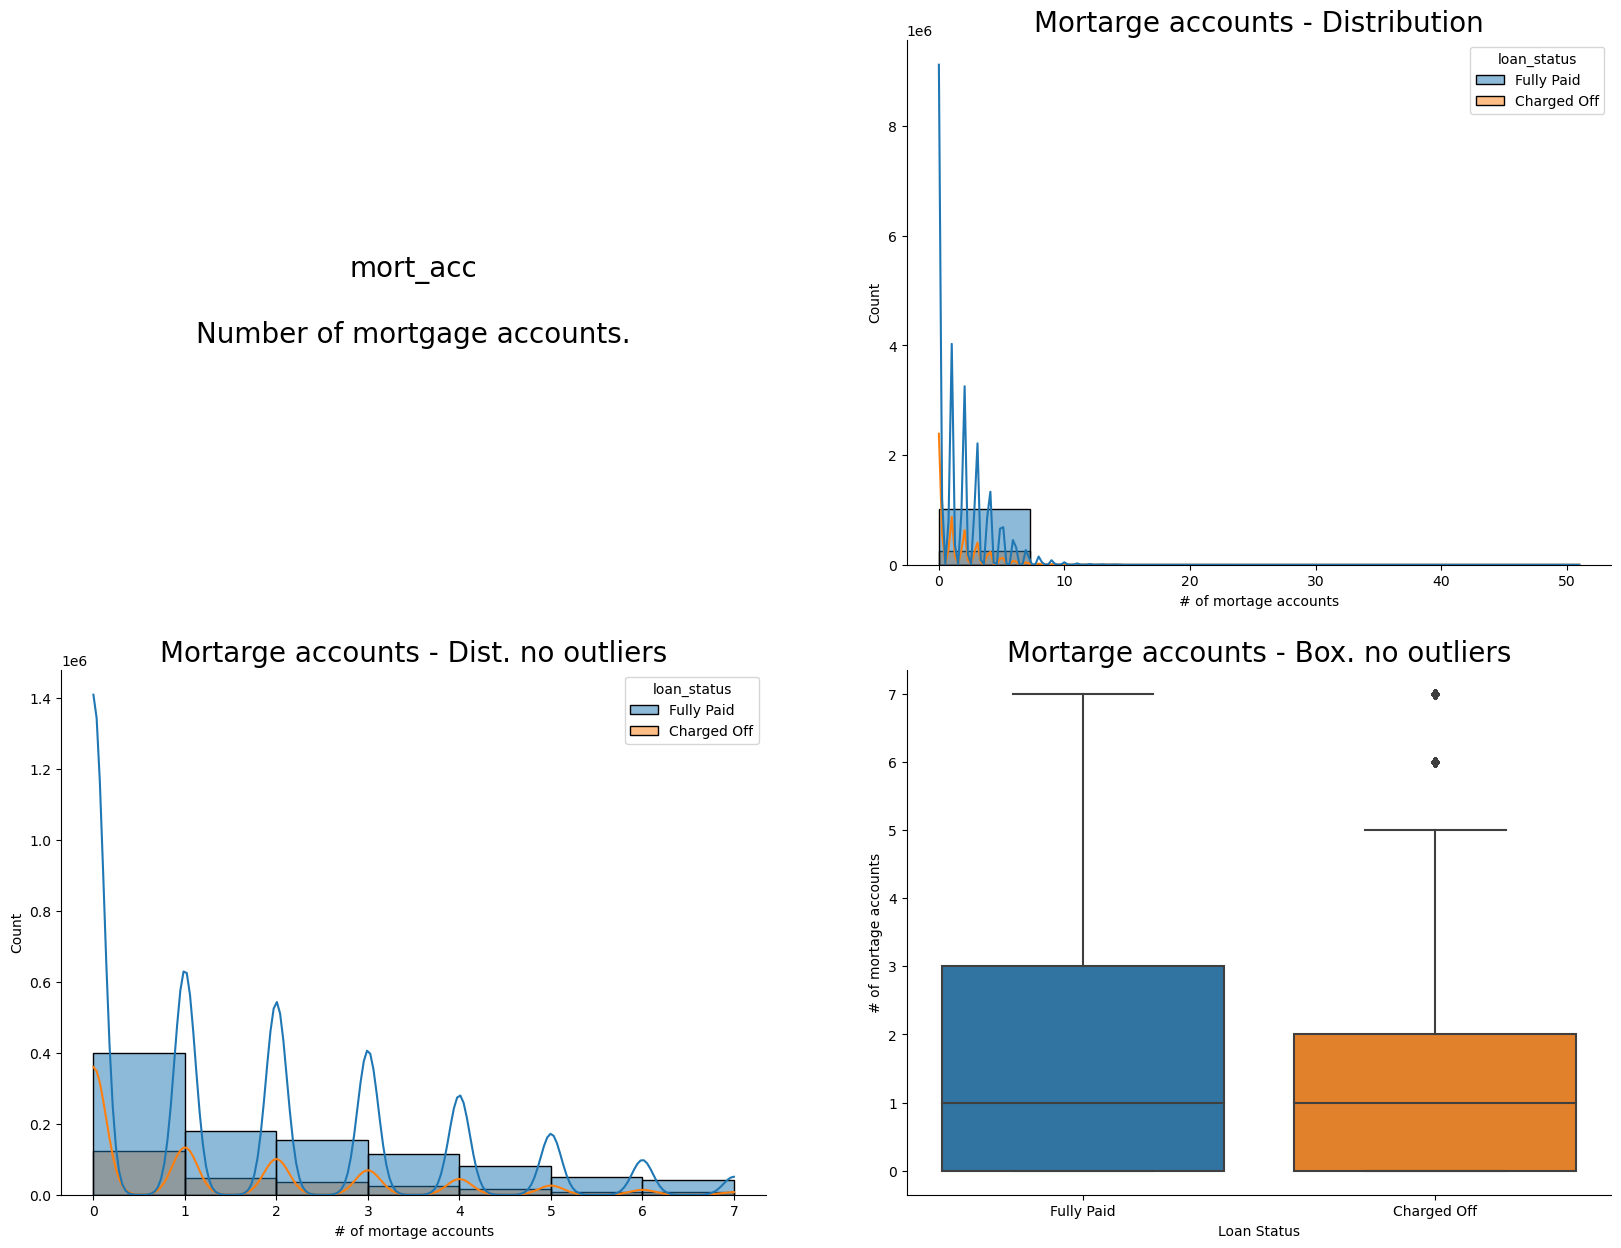

In [39]:

fig, ax =plt.subplots(2,2,figsize=(20,15))

sns.despine()

ax0 = fig.add_subplot(ax[0,0])
ax0.spines[:].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,"mort_acc\n\nNumber of mortgage accounts.",
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=20,
         color="#000000")

ax[0,1].tick_params(axis='x', labelrotation=0)
ax[0,1].set(xlabel='# of mortage accounts', ylabel='')
ax[0,1].set_title('Mortarge accounts - Distribution', size=20)
ax[1,0].tick_params(axis='x', labelrotation=0)
ax[1,0].set(xlabel='# of mortage accounts', ylabel='')
ax[1,0].set_title('Mortarge accounts - Dist. no outliers', size=20)
ax[1,1].set_title('Mortarge accounts - Box. no outliers', size=20)

sns.histplot(data=df_trimmed,x="mort_acc",hue="loan_status",bins=7,
             kde=True,ax=ax[0,1])

# Temporaly removing outliers to get a better visualization
mort_acc=remove_outlier(df_trimmed, "mort_acc")

sns.histplot(data=mort_acc,x="mort_acc",hue="loan_status",bins=7,
             kde=True, ax=ax[1,0])

sns.boxplot(data=mort_acc,x="loan_status",y="mort_acc",ax=ax[1,1]).set(xlabel='Loan Status',
                                                                       ylabel='# of mortage accounts')

`open_acc`

/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

[Text(0.5, 0, 'Loan Status'), Text(0, 0.5, '# of open accounts')]

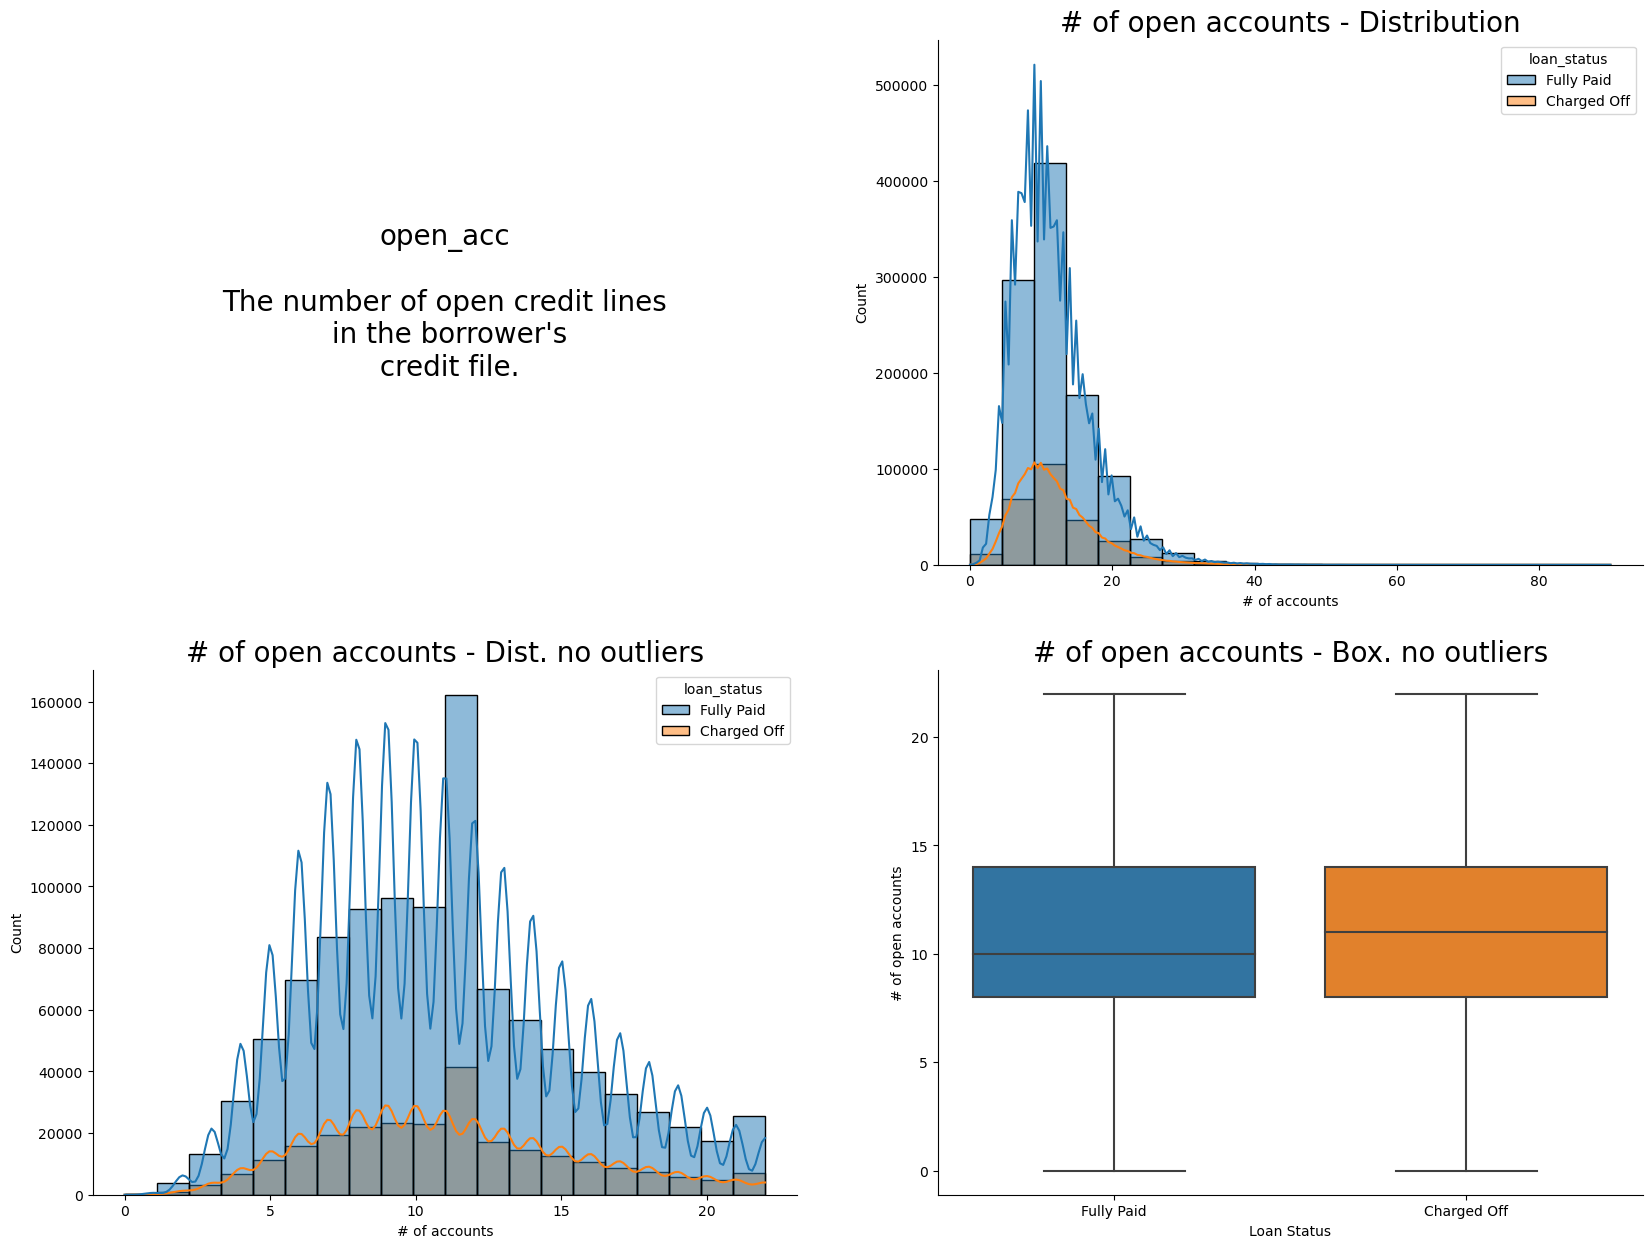

In [40]:
fig, ax =plt.subplots(2,2,figsize=(20,15))

sns.despine()

ax0 = fig.add_subplot(ax[0,0])
ax0.spines[:].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,"open_acc\n\nThe number of open credit lines\n in the borrower's\n credit file.",
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=20,
         color="#000000")

ax[0,1].tick_params(axis='x', labelrotation=0)
ax[0,1].set(xlabel='# of accounts', ylabel='')
ax[0,1].set_title('# of open accounts - Distribution', size=20)
ax[1,0].tick_params(axis='x', labelrotation=0)
ax[1,0].set(xlabel='# of accounts', ylabel='')
ax[1,0].set_title('# of open accounts - Dist. no outliers', size=20)
ax[1,1].set_title('# of open accounts - Box. no outliers', size=20)

sns.histplot(data=df_trimmed,x="open_acc",hue="loan_status",bins=20,
             kde=True,ax=ax[0,1])

# Temporaly removing outliers to get a better visualization
open_acc=remove_outlier(df_trimmed, "open_acc")

sns.histplot(data=open_acc,x="open_acc",hue="loan_status",bins=20,
             kde=True,ax=ax[1,0])
sns.boxplot(data=open_acc,x="loan_status",y="open_acc",ax=ax[1,1]).set(xlabel='Loan Status',
                                                                       ylabel='# of open accounts')

`total_acc`

/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/annguyen/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

[Text(0.5, 0, 'Loan Status'), Text(0, 0.5, 'Total # of accounts')]

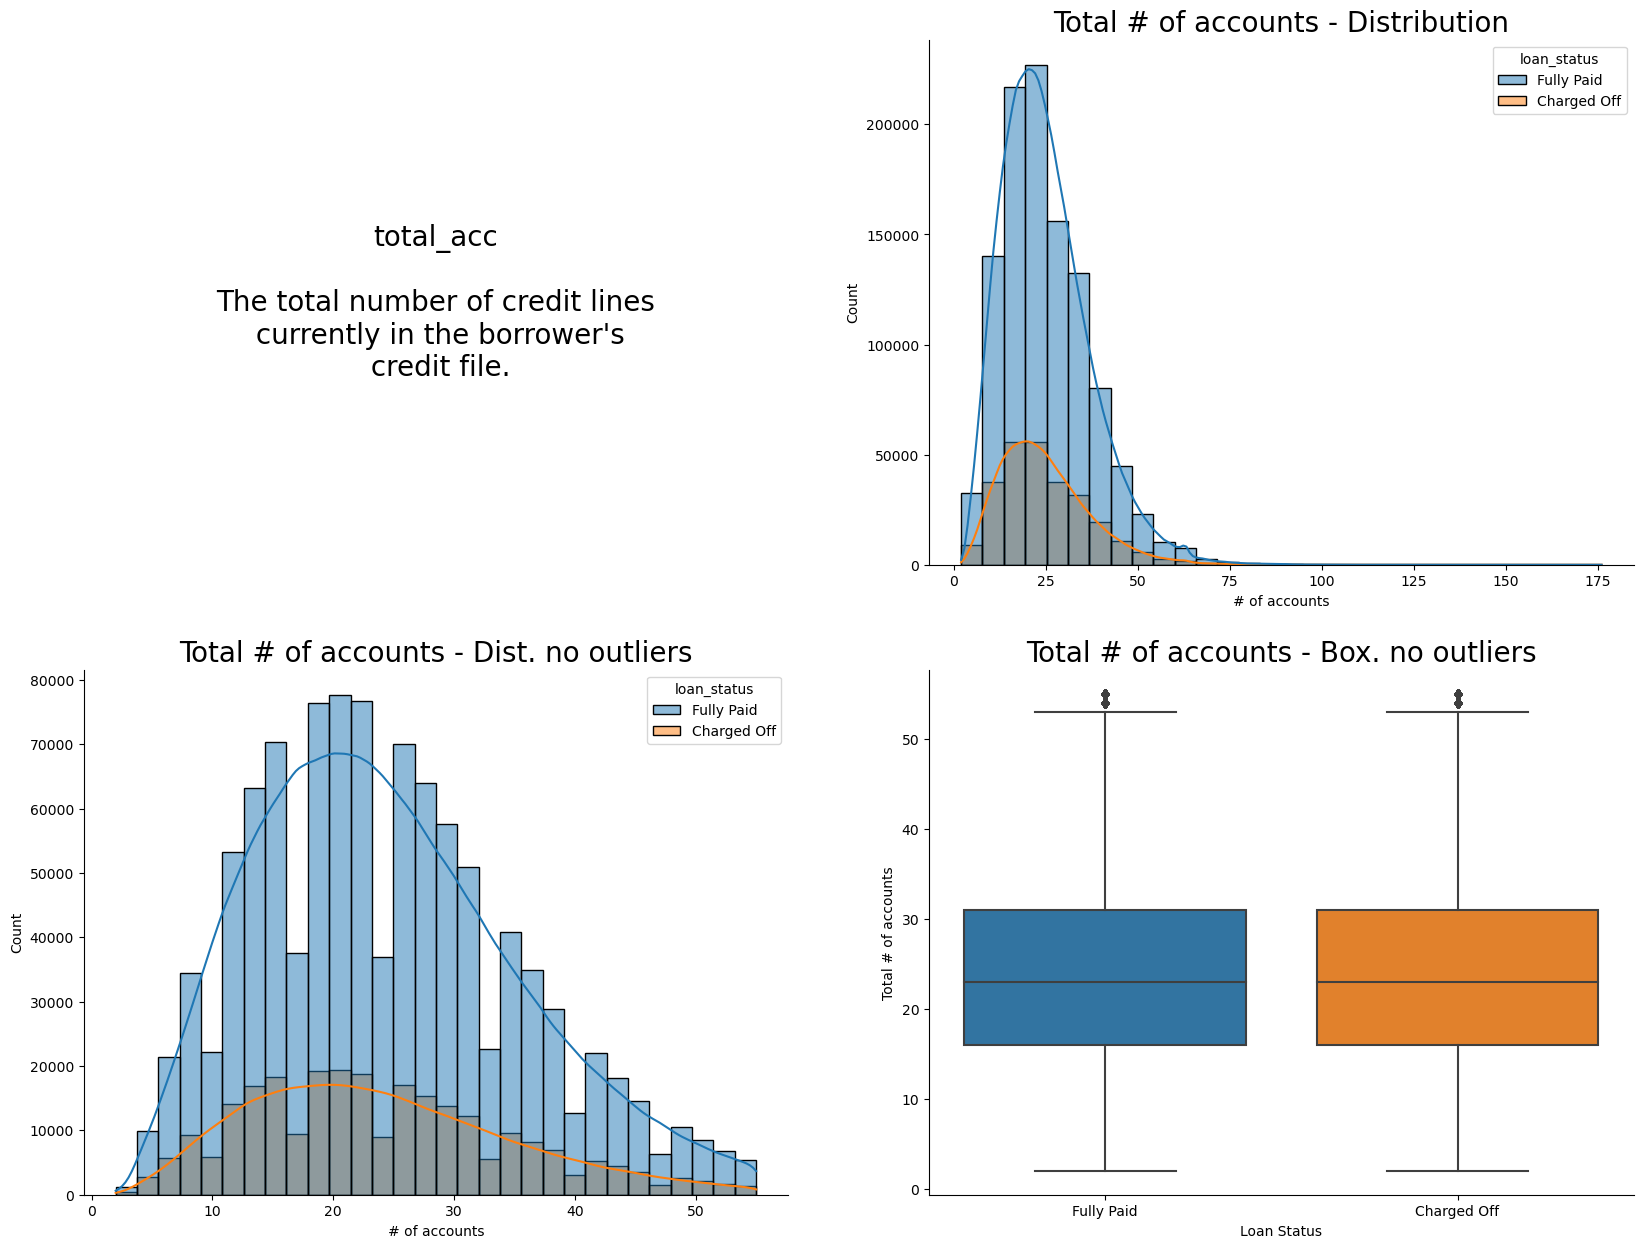

In [41]:
fig, ax =plt.subplots(2,2,figsize=(20,15))

sns.despine()

ax0 = fig.add_subplot(ax[0,0])
ax0.spines[:].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,"total_acc\n\nThe total number of credit lines\n currently in the borrower's\n credit file.",
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=20,
         color="#000000")

ax[0,1].tick_params(axis='x', labelrotation=0)
ax[0,1].set(xlabel='# of accounts', ylabel='')
ax[0,1].set_title('Total # of accounts - Distribution', size=20)
ax[1,0].tick_params(axis='x', labelrotation=0)
ax[1,0].set(xlabel='# of accounts', ylabel='')
ax[1,0].set_title('Total # of accounts - Dist. no outliers', size=20)
ax[1,1].set_title('Total # of accounts - Box. no outliers', size=20)

sns.histplot(data=df_trimmed,x="total_acc",hue="loan_status",bins=30,
             kde=True,ax=ax[0,1])

# Temporaly removing outliers to get a better visualization
total_acc=remove_outlier(df_trimmed, "total_acc")

sns.histplot(data=total_acc,x="total_acc",hue="loan_status",bins=30,
             kde=True,ax=ax[1,0])
sns.boxplot(data=total_acc,x="loan_status",y="total_acc",ax=ax[1,1]).set(xlabel='Loan Status',
                                                                         ylabel='Total # of accounts')

### Data pre-processing

In [42]:
# We inspected that emp_length percentages are pretty much the same. Drop this feature
df_trimmed = df_trimmed.drop(['emp_length'], axis=1)

In [43]:
# We also saw how emp_title has too much unique values. Drop this feature
df_trimmed = df_trimmed.drop(['emp_title'], axis=1)

In [44]:
# grad is a sub category of sub_grade, so drop this feature
df_trimmed = df_trimmed.drop(['grade'], axis=1)

In [45]:
# Show number of missing values and their percentage in the trimmed dataset

dict = {}
for i in list(df_trimmed.columns):
    dict[i] = (df_trimmed[i].isnull().sum(),round(df_trimmed[i].isnull().sum()/len(df_trimmed)*100,2))

pd.DataFrame(dict,index=["# of missing values","% of missing values"]).transpose().sort_values(by=["# of missing values"], ascending=False)

,# of missing values,% of missing values
tot_cur_bal,67527.0,5.02
tot_coll_amt,67527.0,5.02
mort_acc,47281.0,3.51
chargeoff_within_12_mths,56.0,0.00
installment,0.0,0.00
fico_range_high,0.0,0.00
fico_range_low,0.0,0.00
open_acc,0.0,0.00
application_type,0.0,0.00
delinq_amnt,0.0,0.00


Process the missing values

`tot_cur_bal`

In [46]:
# Inspect which feature is highly correlated with tot_cur_bal
df_trimmed.select_dtypes(['float64']).corr()['tot_cur_bal'].sort_values()

int_rate                   -0.085184
tot_coll_amt               -0.001759
chargeoff_within_12_mths    0.006462
delinq_amnt                 0.021669
fico_range_high             0.135332
fico_range_low              0.135332
open_acc                    0.244965
installment                 0.284974
total_acc                   0.311036
loan_amnt                   0.315582
annual_inc                  0.398275
mort_acc                    0.530461
tot_cur_bal                 1.000000
Name: tot_cur_bal, dtype: float64

mort_acc is correlated with tot_cur_bal. So let's fill in the missing values from tot_cur_bal with the mean value corresponding to its mort_acc value.

In [47]:
# Fill missing value in the feature with the feature's mean
df_trimmed['tot_cur_bal'].fillna(df_trimmed['tot_cur_bal'].mean(), inplace=True)

`tot_coll_amt`

In [48]:
# Fill missing value in the feature with the feature's mean
df_trimmed['tot_coll_amt'].fillna(df_trimmed['tot_coll_amt'].mean(), inplace=True)

`mort_acc`

In [49]:
# Fill missing value in the feature with the feature's mean
df_trimmed['mort_acc'].fillna(df_trimmed['mort_acc'].mean(), inplace=True)

chargeoff_within_12_mths feature has very low number of missing values, so we can drop the rows with missing values here.

In [50]:
df_trimmed.dropna(inplace=True)

In [51]:
# Inspect the missing values again to make sure they are cleaned
dict = {}
for i in list(df_trimmed.columns):
    dict[i] = (df_trimmed[i].isnull().sum(),round(df_trimmed[i].isnull().sum()/len(df_trimmed)*100,2))

pd.DataFrame(dict,index=["# of missing values","% of missing values"]).transpose().sort_values(by=["# of missing values"], ascending=False)

,# of missing values,% of missing values
loan_amnt,0.0,0.0
installment,0.0,0.0
fico_range_high,0.0,0.0
fico_range_low,0.0,0.0
open_acc,0.0,0.0
mort_acc,0.0,0.0
tot_cur_bal,0.0,0.0
tot_coll_amt,0.0,0.0
application_type,0.0,0.0
delinq_amnt,0.0,0.0


### Value Encoding

In [52]:
# Encode the loan_status feature
df_trimmed['loan_status'] = df_trimmed['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

df_trimmed.head()

,loan_amnt,installment,loan_status,sub_grade,term,int_rate,home_ownership,annual_inc,verification_status,addr_state,chargeoff_within_12_mths,delinq_amnt,application_type,tot_coll_amt,tot_cur_bal,mort_acc,open_acc,fico_range_low,fico_range_high,total_acc
0,3600.0,123.03,0,C4,36 months,13.99,MORTGAGE,55000.0,Not Verified,PA,0.0,0.0,Individual,722.0,144904.0,1.0,7.0,675.0,679.0,13.0
1,24700.0,820.28,0,C1,36 months,11.99,MORTGAGE,65000.0,Not Verified,SD,0.0,0.0,Individual,0.0,204396.0,4.0,22.0,715.0,719.0,38.0
2,20000.0,432.66,0,B4,60 months,10.78,MORTGAGE,63000.0,Not Verified,IL,0.0,0.0,Joint App,0.0,189699.0,5.0,6.0,695.0,699.0,18.0
4,10400.0,289.91,0,F1,60 months,22.45,MORTGAGE,104433.0,Source Verified,PA,0.0,0.0,Individual,0.0,331730.0,6.0,12.0,695.0,699.0,35.0
5,11950.0,405.18,0,C3,36 months,13.44,RENT,34000.0,Source Verified,GA,0.0,0.0,Individual,0.0,12798.0,0.0,5.0,690.0,694.0,6.0


In [53]:
# Separating the target from the features

y=df_trimmed["loan_status"]
X=df_trimmed.drop(['loan_status'],axis=1)

print(y.head())

0    0
1    0
2    0
4    0
5    0
Name: loan_status, dtype: int64


In [54]:
OH = pd.get_dummies(X[['addr_state',  'verification_status', 'sub_grade','term', 'home_ownership', 'application_type']], drop_first=True)

X=X.drop(['addr_state',  'verification_status', 'sub_grade','term', 'home_ownership', 'application_type'],axis=1)

X = pd.concat([X,OH],axis=1)

In [55]:
X.columns.tolist()

['loan_amnt',
 'installment',
 'int_rate',
 'annual_inc',
 'chargeoff_within_12_mths',
 'delinq_amnt',
 'tot_coll_amt',
 'tot_cur_bal',
 'mort_acc',
 'open_acc',
 'fico_range_low',
 'fico_range_high',
 'total_acc',
 'addr_state_AL',
 'addr_state_AR',
 'addr_state_AZ',
 'addr_state_CA',
 'addr_state_CO',
 'addr_state_CT',
 'addr_state_DC',
 'addr_state_DE',
 'addr_state_FL',
 'addr_state_GA',
 'addr_state_HI',
 'addr_state_IA',
 'addr_state_ID',
 'addr_state_IL',
 'addr_state_IN',
 'addr_state_KS',
 'addr_state_KY',
 'addr_state_LA',
 'addr_state_MA',
 'addr_state_MD',
 'addr_state_ME',
 'addr_state_MI',
 'addr_state_MN',
 'addr_state_MO',
 'addr_state_MS',
 'addr_state_MT',
 'addr_state_NC',
 'addr_state_ND',
 'addr_state_NE',
 'addr_state_NH',
 'addr_state_NJ',
 'addr_state_NM',
 'addr_state_NV',
 'addr_state_NY',
 'addr_state_OH',
 'addr_state_OK',
 'addr_state_OR',
 'addr_state_PA',
 'addr_state_RI',
 'addr_state_SC',
 'addr_state_SD',
 'addr_state_TN',
 'addr_state_TX',
 'addr_stat

In [56]:
X.shape

(1345254, 106)

### Model Building

In [57]:
# Splitting the dataset between training and validation set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=29)

In [58]:
# Min Max scaling the features  

scaler = MinMaxScaler()

# fit and transfrom
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [59]:
!pip3 install tensorflow

In [60]:
model = Sequential()

model.add(Dense(78, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(39, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(19, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense (units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
history = model.fit(x=X_train, y=y_train, epochs=100, batch_size=300, validation_data=(X_test, y_test))

Epoch 1/100
3588/3588 [==============================] - 11s 3ms/step - loss: 0.4632 - accuracy: 0.8005 - val_loss: 0.4559 - val_accuracy: 0.8009
Epoch 2/100
3588/3588 [==============================] - 10s 3ms/step - loss: 0.4579 - accuracy: 0.8012 - val_loss: 0.4548 - val_accuracy: 0.8017
Epoch 3/100
3588/3588 [==============================] - 10s 3ms/step - loss: 0.4569 - accuracy: 0.8013 - val_loss: 0.4549 - val_accuracy: 0.8017
Epoch 4/100
3588/3588 [==============================] - 10s 3ms/step - loss: 0.4563 - accuracy: 0.8011 - val_loss: 0.4543 - val_accuracy: 0.8018
Epoch 5/100
3588/3588 [==============================] - 10s 3ms/step - loss: 0.4559 - accuracy: 0.8014 - val_loss: 0.4542 - val_accuracy: 0.8018
Epoch 6/100
3588/3588 [==============================] - 9s 3ms/step - loss: 0.4557 - accuracy: 0.8014 - val_loss: 0.4548 - val_accuracy: 0.8011
Epoch 7/100
3588/3588 [==============================] - 10s 3ms/step - loss: 0.4553 - accuracy: 0.8015 - val_loss: 0.4541 - 

Epoch 57/100
3588/3588 [==============================] - 10s 3ms/step - loss: 0.4522 - accuracy: 0.8024 - val_loss: 0.4539 - val_accuracy: 0.8012
Epoch 58/100
3588/3588 [==============================] - 10s 3ms/step - loss: 0.4522 - accuracy: 0.8026 - val_loss: 0.4534 - val_accuracy: 0.8020
Epoch 59/100
3588/3588 [==============================] - 9s 3ms/step - loss: 0.4520 - accuracy: 0.8028 - val_loss: 0.4537 - val_accuracy: 0.8012
Epoch 60/100
3588/3588 [==============================] - 10s 3ms/step - loss: 0.4522 - accuracy: 0.8026 - val_loss: 0.4538 - val_accuracy: 0.8015
Epoch 61/100
3588/3588 [==============================] - 10s 3ms/step - loss: 0.4521 - accuracy: 0.8025 - val_loss: 0.4541 - val_accuracy: 0.8011
Epoch 62/100
3588/3588 [==============================] - 9s 3ms/step - loss: 0.4520 - accuracy: 0.8028 - val_loss: 0.4543 - val_accuracy: 0.8008
Epoch 63/100
3588/3588 [==============================] - 10s 3ms/step - loss: 0.4520 - accuracy: 0.8027 - val_loss: 0.4

In [74]:
prediction_probs = model.predict(X_test)
predictions = (model.predict(X_test) > 0.5).astype('int64')

8408/8408 [==============================] - 9s 1ms/step


<Axes: >

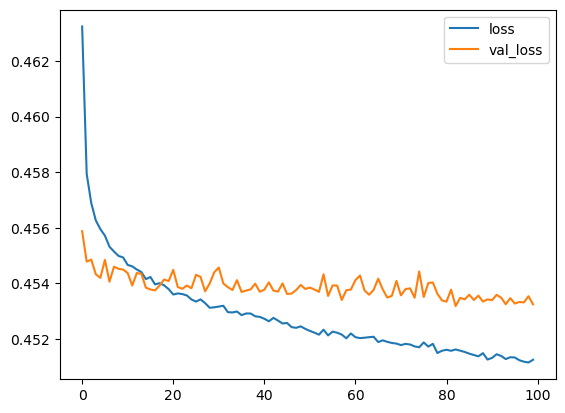

In [75]:
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot()

In [76]:
accuracy = accuracy_score(y_test, predictions)

print(f'The accuraccy score is {accuracy * 100}%')

The accuraccy score is 80.20598325224586%


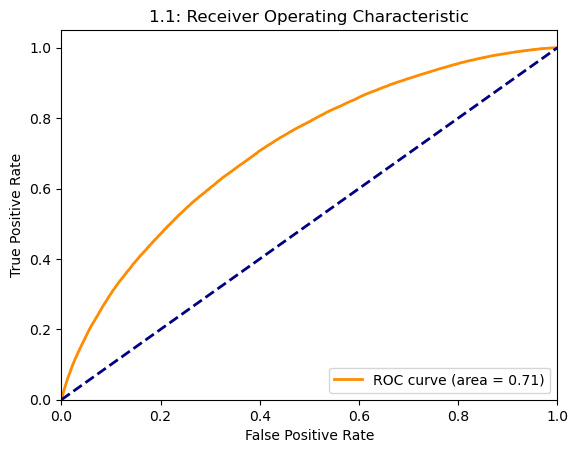

In [82]:
# Plot AUC curve
fpr, tpr, thresholds = roc_curve(y_test, prediction_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('1.1: Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [86]:
print('\t\t1.3: Classification Report\n')
print(classification_report(y_test, predictions))

		1.3: Classification Report

              precision    recall  f1-score   support

           0       0.81      0.99      0.89    215344
           1       0.55      0.04      0.08     53707

    accuracy                           0.80    269051
   macro avg       0.68      0.52      0.49    269051
weighted avg       0.76      0.80      0.73    269051



Text(0.5, 1.0, '1.2: Confusion Matrix Heatmap')

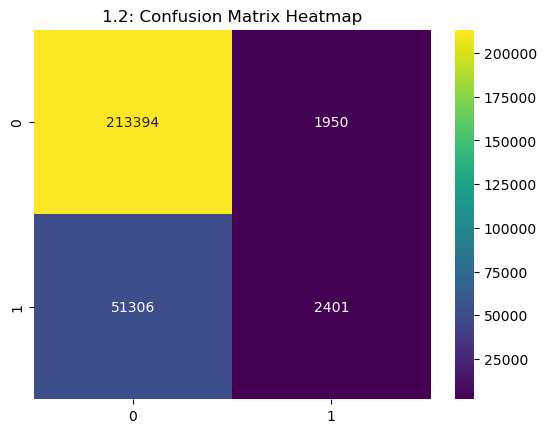

In [81]:
sns.heatmap(confusion_matrix(y_test, predictions), fmt='d', annot=True, cmap='viridis')
plt.title('1.2: Confusion Matrix Heatmap')